In [1]:
from google.colab import drive
drive.mount('/content/drive')

image_path_one = "./drive/MyDrive/Colab Notebooks/landarea.png"
image_path_two = "./drive/MyDrive/Colab Notebooks/image_03.png"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Raster Resizing/Repositioning Model

Phase 1: Generating Solid Masks...
Phase 2: Sampling points inside Source Polygon A...
Phase 3: Greedy Monte Carlo (Maximal Overlap Search)...
   Step 0: Points overlapping: 5413


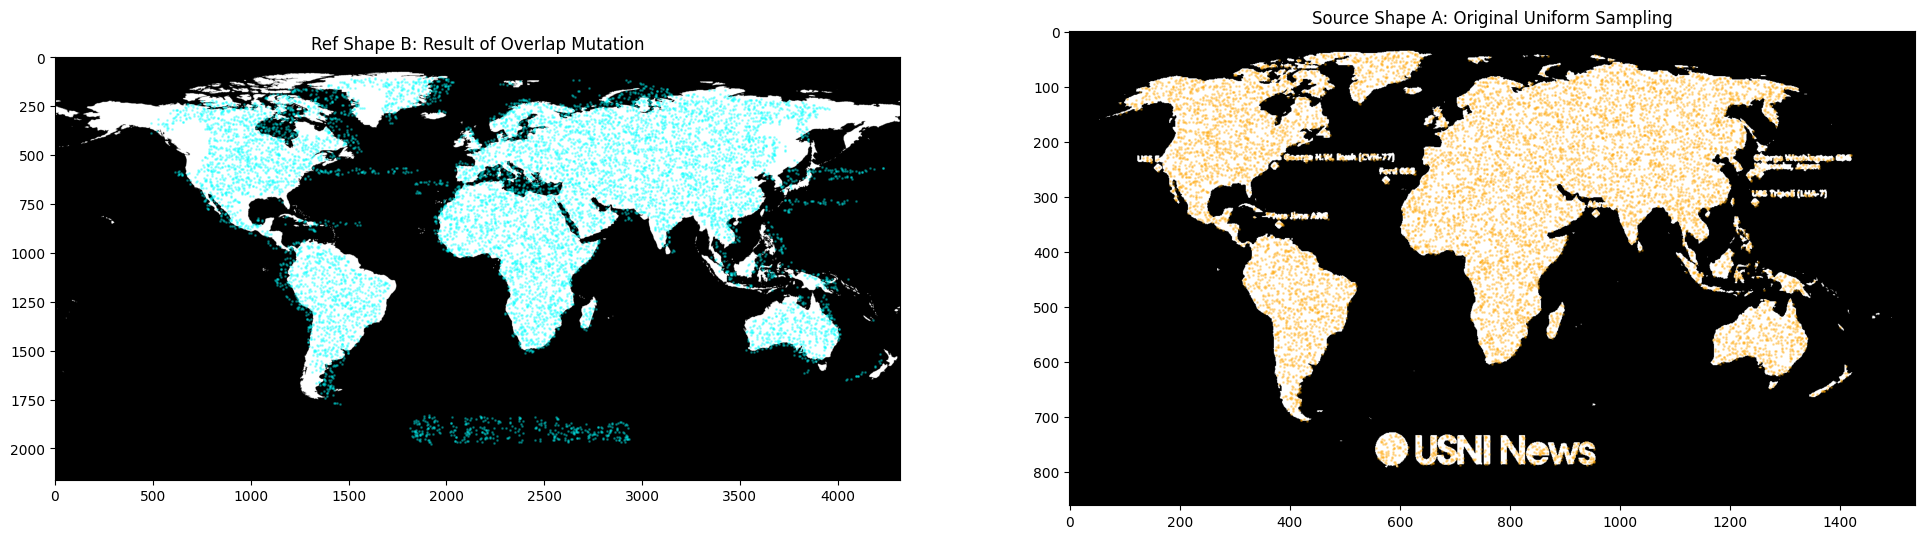

Phase 4: Creating smooth warp from winning coefficients...


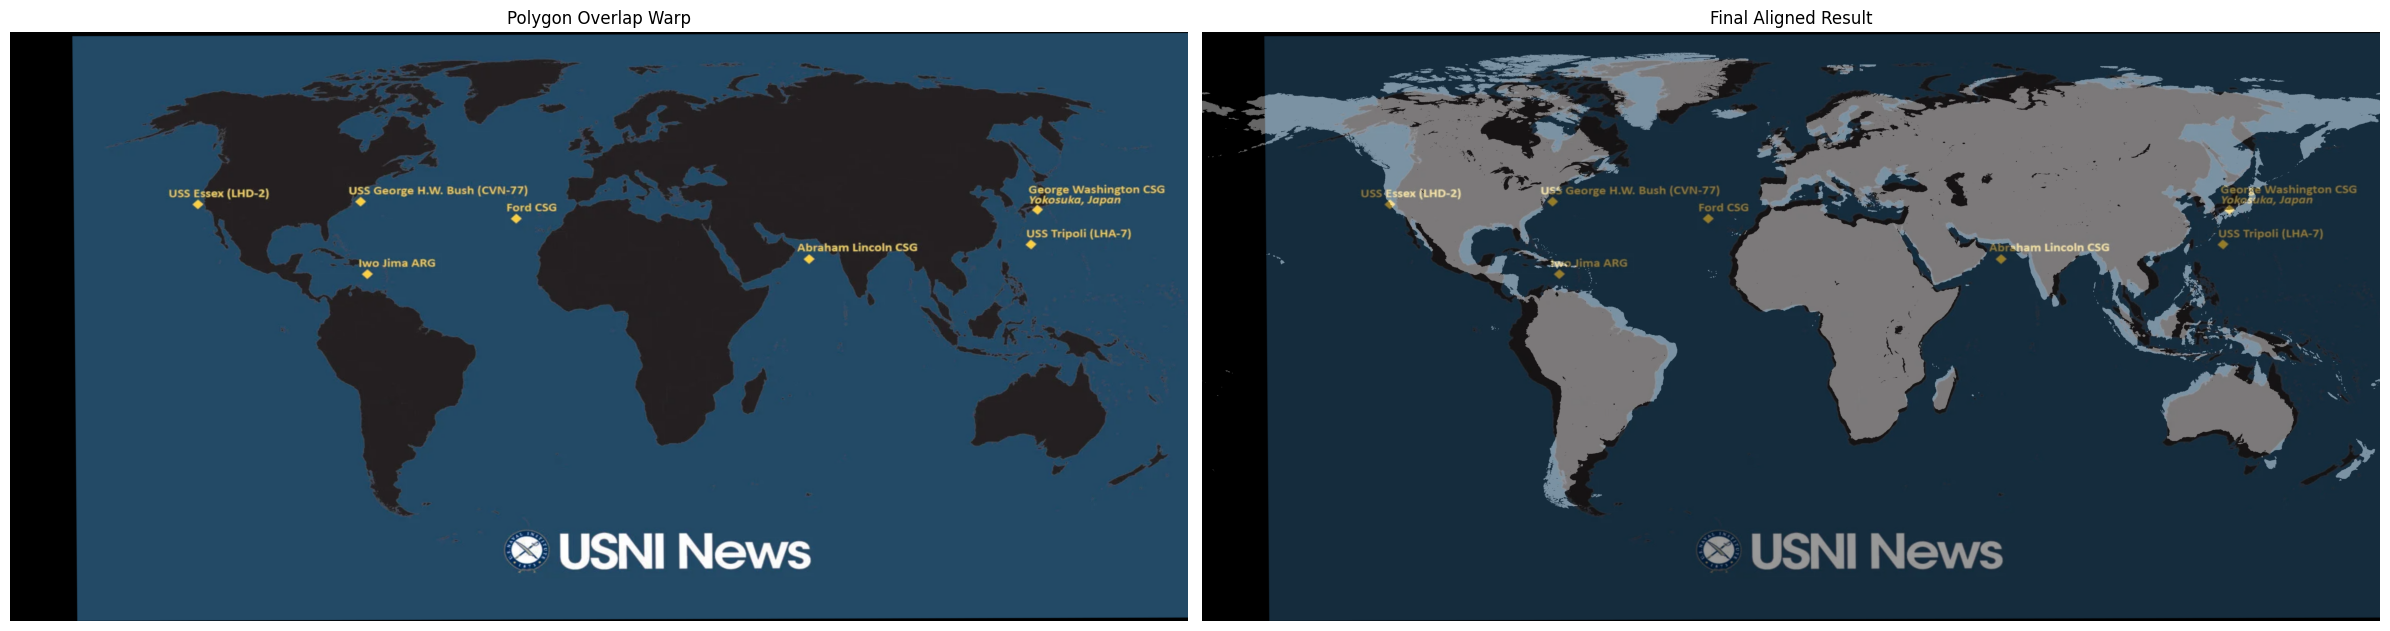

In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_solid_mask(img):
    """Detects land and fills interiors to create a solid manifold."""
    small = cv2.resize(img, (200, 200), interpolation=cv2.INTER_AREA)
    colors, counts = np.unique(small.reshape(-1, 3), axis=0, return_counts=True)
    sea_color = colors[np.argmax(counts)]
    diff = np.linalg.norm(img.astype(int) - sea_color.astype(int), axis=2)
    mask = np.where(diff > 35, 255, 0).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    solid = np.zeros_like(mask)
    cv2.drawContours(solid, contours, -1, 255, -1)
    return solid

def get_poly_features(pts_norm):
    """Calculates polynomial features on NORMALIZED [0, 1] coordinates."""
    x = pts_norm[:, 0]
    y = pts_norm[:, 1]
    return np.column_stack([
        np.ones(len(x)), x, y,
        x**2, x*y, y**2,
        x**3, (x**2)*y, x*(y**2), y**3
    ])

def monte_carlo_overlap_alignment(image_path_one, image_path_two):
    ref_img = cv2.imread(image_path_one)
    samp_img = cv2.imread(image_path_two)
    h_r, w_r = ref_img.shape[:2]
    h_s, w_s = samp_img.shape[:2]

    print("Phase 1: Generating Solid Masks...")
    mask_b = get_solid_mask(ref_img) # Reference Target
    mask_a = get_solid_mask(samp_img) # Sample Source

    print("Phase 2: Sampling points inside Source Polygon A...")
    y_idx, x_idx = np.where(mask_a == 255)
    sel = np.random.choice(len(y_idx), 9500, replace=False)
    src_pts = np.column_stack((x_idx[sel], y_idx[sel])).astype(np.float32)

    # Normalize source points to [0, 1] for stable polynomial math
    src_pts_norm = src_pts.copy()
    src_pts_norm[:, 0] /= w_s
    src_pts_norm[:, 1] /= h_s
    feat_a = get_poly_features(src_pts_norm)

    print("Phase 3: Greedy Monte Carlo (Maximal Overlap Search)...")
    # Coefficients: [1, x, y, x2, xy, y2, x3, x2y, xy2, y3]
    # Initial state: Simple scale to target size
    best_cx = np.zeros(10); best_cy = np.zeros(10)
    best_cx[1] = w_r  # Map normalized X back to Reference Width
    best_cy[2] = h_r  # Map normalized Y back to Reference Height

    best_score = 0
    mut_power = 2.0 # Initial mutation jump size (pixels)

    for i in range(3000):
        # Mutate coefficients (very tiny changes for high-order terms)
        power_vec = np.array([5.0, 1.0, 1.0, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01, 0.01])
        noise_x = np.random.normal(0, mut_power, 10) * power_vec
        noise_y = np.random.normal(0, mut_power, 10) * power_vec

        test_cx = best_cx + noise_x
        test_cy = best_cy + noise_y

        # Warp the points and check overlap
        proj_x = (feat_a @ test_cx).astype(int)
        proj_y = (feat_a @ test_cy).astype(int)

        # Clip to image bounds
        v = (proj_x >= 0) & (proj_x < w_r) & (proj_y >= 0) & (proj_y < h_r)
        score = np.sum(mask_b[proj_y[v], proj_x[v]] == 255) if np.any(v) else 0

        if score > best_score:
            best_score = score
            best_cx, best_cy = test_cx, test_cy
            if i % 500 == 0: print(f"   Step {i}: Points overlapping: {score}")

        # Slowly reduce mutation for precision (annealing)
        mut_power *= 0.9995

    # Final positions
    dst_pts = np.column_stack((feat_a @ best_cx, feat_a @ best_cy))

    # Plot Clouds
    plt.figure(figsize=(24, 8))
    plt.subplot(1, 2, 1); plt.imshow(mask_b, cmap='gray')
    plt.scatter(dst_pts[:, 0], dst_pts[:, 1], c='cyan', s=1, alpha=0.3)
    plt.title("Ref Shape B: Result of Overlap Mutation")

    plt.subplot(1, 2, 2); plt.imshow(mask_a, cmap='gray')
    plt.scatter(src_pts[:, 0], src_pts[:, 1], c='orange', s=1, alpha=0.3)
    plt.title("Source Shape A: Original Uniform Sampling")
    plt.show()

    print("Phase 4: Creating smooth warp from winning coefficients...")
    # Calculate inverse mapping (Every pixel in Ref -> Where was it in Sample?)
    x_range, y_range = np.arange(w_r), np.arange(h_r)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    # Normalize the grid
    grid_norm = np.column_stack([grid_x.ravel() / w_r, grid_y.ravel() / h_r]).astype(np.float32)

    # Solve for Inverse: How to get back to src_pts from normalized dst_pts?
    dst_pts_norm = dst_pts.copy()
    dst_pts_norm[:, 0] /= w_r
    dst_pts_norm[:, 1] /= h_r
    feat_dst = get_poly_features(dst_pts_norm)
    inv_cx, _, _, _ = np.linalg.lstsq(feat_dst, src_pts[:, 0], rcond=None)
    inv_cy, _, _, _ = np.linalg.lstsq(feat_dst, src_pts[:, 1], rcond=None)

    # Apply warp
    map_x = np.zeros(w_r * h_r, dtype=np.float32)
    map_y = np.zeros(w_r * h_r, dtype=np.float32)
    chunk_size = 500000
    for i in range(0, len(grid_norm), chunk_size):
        end = i + chunk_size
        feat = get_poly_features(grid_norm[i:end])
        map_x[i:end] = feat @ inv_cx
        map_y[i:end] = feat @ inv_cy

    map_x = map_x.reshape(h_r, w_r).astype(np.float32)
    map_y = map_y.reshape(h_r, w_r).astype(np.float32)

    warped_img = cv2.remap(samp_img, map_x, map_y, cv2.INTER_LINEAR)
    overlay = cv2.addWeighted(ref_img, 0.4, warped_img, 0.6, 0)

    plt.figure(figsize=(24, 10))
    plt.subplot(1, 2, 1); plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
    plt.title("Polygon Overlap Warp"); plt.axis('off')
    plt.subplot(1, 2, 2); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Final Aligned Result"); plt.axis('off')
    plt.tight_layout(); plt.show()

    return warped_img

# Execute
warped_result = monte_carlo_overlap_alignment(image_path_one, image_path_two)

# Advanced Mesh Warp Models (Stochastic Gradient Descent)

In [37]:
from google.colab import drive
drive.mount('/content/drive')

image_path_one = "./drive/MyDrive/Colab Notebooks/landarea.png"  # Reference
image_path_two = "./drive/MyDrive/Colab Notebooks/image_03.png"  # Source

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree, Delaunay
from scipy.interpolate import RBFInterpolator


# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def get_solid_mask(img):
    """Detects land and fills interiors to create a solid manifold."""
    small = cv2.resize(img, (200, 200), interpolation=cv2.INTER_AREA)
    colors, counts = np.unique(
        small.reshape(-1, 3), axis=0, return_counts=True
    )
    sea_color = colors[np.argmax(counts)]
    diff = np.linalg.norm(
        img.astype(int) - sea_color.astype(int), axis=2
    )
    mask = np.where(diff > 35, 255, 0).astype(np.uint8)
    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    solid = np.zeros_like(mask)
    cv2.drawContours(solid, contours, -1, 255, -1)
    return solid


def get_poly_features(pts_norm):
    """Cubic polynomial features on normalized [0,1] coordinates."""
    x = pts_norm[:, 0]
    y = pts_norm[:, 1]
    return np.column_stack([
        np.ones(len(x)), x, y,
        x**2, x * y, y**2,
        x**3, (x**2) * y, x * (y**2), y**3,
    ])


def sample_contour_points(mask, n_points=500):
    """Sample n_points evenly distributed across all significant contours."""
    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )
    contours = [c.squeeze() for c in contours if len(c) >= 30]
    contours = [c for c in contours if c.ndim == 2]
    if not contours:
        return np.array([], dtype=np.float32).reshape(0, 2)

    total_len = sum(len(c) for c in contours)
    all_pts = []
    for c in contours:
        n = max(2, int(n_points * len(c) / total_len))
        indices = np.linspace(0, len(c) - 1, n, dtype=int)
        all_pts.append(c[indices])
    return np.vstack(all_pts).astype(np.float32)


def sample_interior_grid(mask, spacing=80):
    """Sample grid points that fall inside the mask."""
    h, w = mask.shape
    pts = []
    for y in range(spacing // 2, h, spacing):
        for x in range(spacing // 2, w, spacing):
            if mask[y, x] == 255:
                pts.append([x, y])
    if pts:
        return np.array(pts, dtype=np.float32)
    return np.array([], dtype=np.float32).reshape(0, 2)


# =============================================================================
# MAIN MESH WARP PIPELINE
# =============================================================================

def mesh_warp_alignment(path_ref, path_src):
    ref_img = cv2.imread(path_ref)
    src_img = cv2.imread(path_src)
    if ref_img is None or src_img is None:
        raise FileNotFoundError("Could not load one or both images.")
    h_r, w_r = ref_img.shape[:2]
    h_s, w_s = src_img.shape[:2]

    # ------------------------------------------------------------------
    # PHASE 1 — Solid land masks
    # ------------------------------------------------------------------
    print("Phase 1: Generating Solid Masks...")
    mask_ref = get_solid_mask(ref_img)
    mask_src = get_solid_mask(src_img)

    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(mask_ref, cmap="gray")
    plt.title("Reference Mask")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(mask_src, cmap="gray")
    plt.title("Source Mask")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------
    # PHASE 2 — Monte Carlo polynomial overlap (rough global alignment)
    # ------------------------------------------------------------------
    print("Phase 2: Sampling points inside Source mask...")
    y_idx, x_idx = np.where(mask_src == 255)
    n_sample = min(9500, len(y_idx))
    sel = np.random.choice(len(y_idx), n_sample, replace=False)
    mc_src = np.column_stack((x_idx[sel], y_idx[sel])).astype(np.float32)

    mc_src_norm = mc_src.copy()
    mc_src_norm[:, 0] /= w_s
    mc_src_norm[:, 1] /= h_s
    feat_mc = get_poly_features(mc_src_norm)

    print("Phase 3: Greedy Monte Carlo (Maximal Overlap Search)...")
    best_cx = np.zeros(10)
    best_cy = np.zeros(10)
    best_cx[1] = w_r  # scale normalised X → ref width
    best_cy[2] = h_r  # scale normalised Y → ref height
    best_score = 0
    mut_power = 2.0

    for i in range(4000):
        pv = np.array(
            [5.0, 1.0, 1.0, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01, 0.01]
        )
        noise_x = np.random.normal(0, mut_power, 10) * pv
        noise_y = np.random.normal(0, mut_power, 10) * pv

        test_cx = best_cx + noise_x
        test_cy = best_cy + noise_y

        proj_x = (feat_mc @ test_cx).astype(int)
        proj_y = (feat_mc @ test_cy).astype(int)

        v = (
            (proj_x >= 0)
            & (proj_x < w_r)
            & (proj_y >= 0)
            & (proj_y < h_r)
        )
        score = (
            np.sum(mask_ref[proj_y[v], proj_x[v]] == 255)
            if np.any(v)
            else 0
        )

        if score > best_score:
            best_score = score
            best_cx = test_cx.copy()
            best_cy = test_cy.copy()
            if i % 500 == 0:
                print(f"   Step {i}: overlapping = {score}")

        mut_power *= 0.9995

    print(f"   Final overlap score: {best_score}")

    # ------------------------------------------------------------------
    # PHASE 4 — Extract control-point pairs (src ↔ dst)
    # ------------------------------------------------------------------
    print("Phase 4: Extracting control points (contours + interior)...")

    src_contour = sample_contour_points(mask_src, n_points=400)
    src_interior = sample_interior_grid(mask_src, spacing=60)
    src_ctrl = np.vstack([src_contour, src_interior])
    n_contour = len(src_contour)

    # Project forward through the polynomial → initial dst locations
    src_ctrl_norm = src_ctrl.copy()
    src_ctrl_norm[:, 0] /= w_s
    src_ctrl_norm[:, 1] /= h_s
    feat_ctrl = get_poly_features(src_ctrl_norm)
    dst_ctrl = np.column_stack([feat_ctrl @ best_cx, feat_ctrl @ best_cy])

    print(
        f"   {n_contour} contour pts + "
        f"{len(src_interior)} interior pts = "
        f"{len(src_ctrl)} total"
    )

    # ------------------------------------------------------------------
    # PHASE 5 — Snap projected contour points to nearest ref contour
    # ------------------------------------------------------------------
    print("Phase 5: Refining contour points via nearest-neighbour snap...")

    ref_contour = sample_contour_points(mask_ref, n_points=4000)
    if len(ref_contour) > 0 and n_contour > 0:
        tree = cKDTree(ref_contour)
        dists, idxs = tree.query(dst_ctrl[:n_contour])
        snap_thresh = max(w_r, h_r) * 0.06
        close = dists < snap_thresh
        dst_ctrl[:n_contour][close] = ref_contour[idxs[close]]
        print(
            f"   Snapped {close.sum()}/{n_contour} contour pts "
            f"(thresh={snap_thresh:.0f}px)"
        )

    # Remove any points that left the canvas
    valid = (
        (dst_ctrl[:, 0] >= 0)
        & (dst_ctrl[:, 0] < w_r)
        & (dst_ctrl[:, 1] >= 0)
        & (dst_ctrl[:, 1] < h_r)
        & (src_ctrl[:, 0] >= 0)
        & (src_ctrl[:, 0] < w_s)
        & (src_ctrl[:, 1] >= 0)
        & (src_ctrl[:, 1] < h_s)
    )
    src_ctrl = src_ctrl[valid]
    dst_ctrl = dst_ctrl[valid]

    # ------------------------------------------------------------------
    # PHASE 6 — Boundary anchor points (prevent edges from blowing up)
    # ------------------------------------------------------------------
    print("Phase 6: Adding boundary anchors...")

    n_edge = 25
    bnd_dst, bnd_src = [], []
    for t in np.linspace(0, 1, n_edge, endpoint=False):
        # top
        bnd_dst.append([t * (w_r - 1), 0])
        bnd_src.append([t * (w_s - 1), 0])
        # bottom
        bnd_dst.append([t * (w_r - 1), h_r - 1])
        bnd_src.append([t * (w_s - 1), h_s - 1])
        # left
        bnd_dst.append([0, t * (h_r - 1)])
        bnd_src.append([0, t * (h_s - 1)])
        # right
        bnd_dst.append([w_r - 1, t * (h_r - 1)])
        bnd_src.append([w_s - 1, t * (h_s - 1)])
    # explicit corners
    for dy, sy in [(0, 0), (h_r - 1, h_s - 1)]:
        for dx, sx in [(0, 0), (w_r - 1, w_s - 1)]:
            bnd_dst.append([dx, dy])
            bnd_src.append([sx, sy])

    bnd_dst = np.array(bnd_dst, dtype=np.float32)
    bnd_src = np.array(bnd_src, dtype=np.float32)

    all_dst = np.vstack([dst_ctrl, bnd_dst])
    all_src = np.vstack([src_ctrl, bnd_src])

    # Subsample land control points if too many (RBF gets slow > ~1500)
    max_ctrl = 9000
    n_land = len(dst_ctrl)
    n_bnd = len(bnd_dst)
    if n_land > max_ctrl:
        keep = np.random.choice(n_land, max_ctrl, replace=False)
        land_dst = dst_ctrl[keep]
        land_src = src_ctrl[keep]
        all_dst = np.vstack([land_dst, bnd_dst])
        all_src = np.vstack([land_src, bnd_src])
        print(
            f"   Sub-sampled land ctrl → {max_ctrl}, "
            f"+ {n_bnd} boundary = {len(all_dst)} total"
        )
    else:
        print(f"   {n_land} land + {n_bnd} boundary = {len(all_dst)} total")

    # ------------------------------------------------------------------
    # PHASE 7 — Build TPS warp (Thin Plate Spline via RBF)
    # ------------------------------------------------------------------
    print("Phase 7: Building Thin Plate Spline warp...")

    # We need the INVERSE mapping: for every output pixel (ref space)
    # → where to sample in the source image.
    rbf_x = RBFInterpolator(
        all_dst, all_src[:, 0],
        kernel="thin_plate_spline",
        smoothing=2.0,
    )
    rbf_y = RBFInterpolator(
        all_dst, all_src[:, 1],
        kernel="thin_plate_spline",
        smoothing=2.0,
    )

    # Evaluate on a COARSE grid first, then bilinearly upscale.
    # This is 50-100× faster than evaluating every pixel.
    coarse_step = 8
    coarse_xs = np.arange(0, w_r, coarse_step, dtype=np.float32)
    coarse_ys = np.arange(0, h_r, coarse_step, dtype=np.float32)
    cgx, cgy = np.meshgrid(coarse_xs, coarse_ys)
    coarse_pts = np.column_stack([cgx.ravel(), cgy.ravel()])

    print(
        f"   Evaluating RBF on coarse {cgx.shape[1]}×{cgx.shape[0]} grid "
        f"(step={coarse_step})..."
    )
    coarse_map_x = (
        rbf_x(coarse_pts).reshape(cgx.shape).astype(np.float32)
    )
    coarse_map_y = (
        rbf_y(coarse_pts).reshape(cgy.shape).astype(np.float32)
    )

    # Upscale to full resolution
    map_x = cv2.resize(
        coarse_map_x, (w_r, h_r), interpolation=cv2.INTER_LINEAR
    )
    map_y = cv2.resize(
        coarse_map_y, (w_r, h_r), interpolation=cv2.INTER_LINEAR
    )

    # ------------------------------------------------------------------
    # PHASE 8 — Remap the source image
    # ------------------------------------------------------------------
    print("Phase 8: Warping source image via cv2.remap...")

    warped = cv2.remap(
        src_img,
        map_x,
        map_y,
        cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0),
    )
    overlay = cv2.addWeighted(ref_img, 0.4, warped, 0.6, 0)

    # ------------------------------------------------------------------
    # VISUALISATIONS
    # ------------------------------------------------------------------
    print("Phase 9: Visualising...")

    # --- 1. Control points ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    axes[0].imshow(cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB))
    axes[0].scatter(
        src_ctrl[:, 0], src_ctrl[:, 1], c="cyan", s=2, alpha=0.5
    )
    axes[0].set_title("Source — Control Points")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB))
    axes[1].scatter(
        dst_ctrl[:, 0], dst_ctrl[:, 1], c="red", s=2, alpha=0.5
    )
    axes[1].set_title("Reference — Projected Control Points")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

    # --- 2. Warped result + overlay ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    axes[0].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Mesh-Warped Source")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Overlay  (Ref 40 % + Warped 60 %)")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

    # --- 3. Warp-field heatmaps ---
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    im0 = axes[0].imshow(map_x, cmap="jet")
    axes[0].set_title("Warp Field — X (source column)")
    plt.colorbar(im0, ax=axes[0], shrink=0.6)
    im1 = axes[1].imshow(map_y, cmap="jet")
    axes[1].set_title("Warp Field — Y (source row)")
    plt.colorbar(im1, ax=axes[1], shrink=0.6)
    plt.tight_layout()
    plt.show()

    # --- 4. Delaunay mesh on the output ---
    try:
        tri = Delaunay(all_dst)
        plt.figure(figsize=(16, 10))
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB), alpha=0.7)
        plt.triplot(
            all_dst[:, 0],
            all_dst[:, 1],
            tri.simplices,
            "c-",
            linewidth=0.4,
            alpha=0.6,
        )
        plt.scatter(
            all_dst[:, 0], all_dst[:, 1], c="yellow", s=4, zorder=5
        )
        plt.title("Delaunay Mesh on Output (control-point triangulation)")
        plt.axis("off")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"   (Skipped mesh plot: {e})")

    # --- 5. Warped grid lines (the "Photoshop mesh" look) ---
    plt.figure(figsize=(16, 10))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB), alpha=0.5)
    step = 30
    for y in range(0, h_r, step):
        plt.plot(
            np.arange(w_r),
            map_y[y, :],
            "c-",
            linewidth=0.3,
            alpha=0.6,
        )
    for x in range(0, w_r, step):
        plt.plot(
            map_x[:, x],
            np.arange(h_r),
            "m-",
            linewidth=0.3,
            alpha=0.6,
        )
    plt.title("Dense Warp Grid (inverse-mapping field)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    print("Done ✓")
    return warped, map_x, map_y


# =============================================================================
# EXECUTE
# =============================================================================
warped_result, mx, my = mesh_warp_alignment(
    image_path_one, image_path_two
)

Output hidden; open in https://colab.research.google.com to view.

In [29]:
from google.colab import drive
drive.mount('/content/drive')

image_path_one = "./drive/MyDrive/Colab Notebooks/landarea.png"
image_path_two = "./drive/MyDrive/Colab Notebooks/image_03.png"

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# ─────────────────────────────────────────────────────────────────────
#  MASK EXTRACTION (same as your original)
# ─────────────────────────────────────────────────────────────────────

def get_solid_mask(img):
    """Detects land and fills interiors to create a solid manifold."""
    small = cv2.resize(img, (200, 200), interpolation=cv2.INTER_AREA)
    colors, counts = np.unique(
        small.reshape(-1, 3), axis=0, return_counts=True
    )
    sea_color = colors[np.argmax(counts)]
    diff = np.linalg.norm(
        img.astype(int) - sea_color.astype(int), axis=2
    )
    mask = np.where(diff > 35, 255, 0).astype(np.uint8)
    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    solid = np.zeros_like(mask)
    cv2.drawContours(solid, contours, -1, 255, -1)
    return solid


# ─────────────────────────────────────────────────────────────────────
#  LOSS FUNCTIONS
# ─────────────────────────────────────────────────────────────────────

def dice_loss(pred, target, smooth=1.0):
    """Differentiable Dice loss – great for shape overlap."""
    p = pred.view(-1)
    t = target.view(-1)
    inter = (p * t).sum()
    return 1.0 - (2.0 * inter + smooth) / (
        p.sum() + t.sum() + smooth
    )


def tv_loss(disp):
    """Total-variation on the displacement field → smoothness."""
    dx = disp[:, :, :, 1:] - disp[:, :, :, :-1]
    dy = disp[:, :, 1:, :] - disp[:, :, :-1, :]
    return dx.pow(2).mean() + dy.pow(2).mean()


def fold_loss(grid):
    """
    Penalise mesh folding by requiring a positive Jacobian determinant
    everywhere.  grid: [1, H, W, 2]  (output of the warp).
    """
    # Finite differences along spatial dims
    # dg/dcol
    dg_dc_x = grid[:, :, 1:, 0] - grid[:, :, :-1, 0]
    dg_dc_y = grid[:, :, 1:, 1] - grid[:, :, :-1, 1]
    # dg/drow
    dg_dr_x = grid[:, 1:, :, 0] - grid[:, :-1, :, 0]
    dg_dr_y = grid[:, 1:, :, 1] - grid[:, :-1, :, 1]
    # Crop to same spatial size
    dg_dc_x = dg_dc_x[:, :-1, :];  dg_dc_y = dg_dc_y[:, :-1, :]
    dg_dr_x = dg_dr_x[:, :, :-1];  dg_dr_y = dg_dr_y[:, :, :-1]
    det = dg_dc_x * dg_dr_y - dg_dc_y * dg_dr_x
    return F.relu(-det + 0.05).mean()


# ─────────────────────────────────────────────────────────────────────
#  CORE WARP HELPER
# ─────────────────────────────────────────────────────────────────────

def make_identity_grid(h, w, device):
    """Returns a [1, H, W, 2] identity sampling grid in [-1, 1]."""
    yy = torch.linspace(-1, 1, h, device=device)
    xx = torch.linspace(-1, 1, w, device=device)
    gy, gx = torch.meshgrid(yy, xx, indexing="ij")
    return torch.stack([gx, gy], dim=-1).unsqueeze(0)  # [1,H,W,2]


def warp(src, disp, out_h, out_w):
    """
    Warp `src` (NCHW) by upsampling a coarse displacement field `disp`
    (N,2,mh,mw) to (out_h, out_w) and adding it to the identity grid.

    Returns  warped_image, sampling_grid
    """
    device = src.device
    disp_full = F.interpolate(
        disp, size=(out_h, out_w),
        mode="bicubic", align_corners=True
    )                                                   # [1,2,H,W]
    identity = make_identity_grid(out_h, out_w, device) # [1,H,W,2]
    grid = identity.clone()
    grid[..., 0] = grid[..., 0] + disp_full[:, 0]      # x offset
    grid[..., 1] = grid[..., 1] + disp_full[:, 1]      # y offset
    warped = F.grid_sample(
        src, grid, mode="bilinear",
        padding_mode="border", align_corners=True
    )
    return warped, grid


# ─────────────────────────────────────────────────────────────────────
#  VISUALISATION HELPERS
# ─────────────────────────────────────────────────────────────────────

def show_mask_comparison(warped_mask, ref_mask, title=""):
    """Side-by-side: warped source mask vs reference mask."""
    wm = warped_mask[0, 0].cpu().numpy()
    rm = ref_mask[0, 0].cpu().numpy()
    fig, axes = plt.subplots(1, 3, figsize=(21, 5))
    axes[0].imshow(wm, cmap="gray");  axes[0].set_title("Warped Source Mask")
    axes[1].imshow(rm, cmap="gray");  axes[1].set_title("Reference Mask")
    # Overlap visualisation: green=both, red=ref only, blue=src only
    rgb = np.zeros((*rm.shape, 3))
    rgb[..., 1] = (wm > 0.5) & (rm > 0.5)        # green = overlap
    rgb[..., 0] = (rm > 0.5) & (wm <= 0.5)        # red   = ref only
    rgb[..., 2] = (wm > 0.5) & (rm <= 0.5)        # blue  = src only
    axes[2].imshow(rgb);  axes[2].set_title("Overlap (G=hit R=miss B=extra)")
    for ax in axes: ax.axis("off")
    if title:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout(); plt.show()


def show_mesh(grid_tensor, ref_img_np, step=8, title="Mesh"):
    """Draw the deformed mesh on top of the reference image."""
    g = grid_tensor[0].cpu().numpy()                # [H,W,2]
    h, w = g.shape[:2]
    # Denormalise from [-1,1] to pixel coords
    gx = (g[..., 0] + 1) / 2 * w
    gy = (g[..., 1] + 1) / 2 * h
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.imshow(ref_img_np)
    # horizontal lines
    for r in range(0, h, step):
        ax.plot(gx[r, :], gy[r, :], "c-", lw=0.4, alpha=0.7)
    # vertical lines
    for c in range(0, w, step):
        ax.plot(gx[:, c], gy[:, c], "c-", lw=0.4, alpha=0.7)
    ax.set_title(title); ax.axis("off")
    plt.tight_layout(); plt.show()


# ─────────────────────────────────────────────────────────────────────
#  MAIN: COARSE-TO-FINE SGD MESH WARP
# ─────────────────────────────────────────────────────────────────────

def sgd_mesh_warp(image_path_one, image_path_two):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}\n")

    # --- load ---------------------------------------------------------
    ref_bgr = cv2.imread(image_path_one)
    src_bgr = cv2.imread(image_path_two)
    h_r, w_r = ref_bgr.shape[:2]
    h_s, w_s = src_bgr.shape[:2]
    print(f"Reference : {w_r}×{h_r}")
    print(f"Source    : {w_s}×{h_s}")

    # --- masks --------------------------------------------------------
    print("\n▸ Phase 1: Generating solid land masks …")
    mask_ref = get_solid_mask(ref_bgr)
    mask_src = get_solid_mask(src_bgr)

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1); plt.imshow(mask_ref, cmap="gray")
    plt.title("Reference mask"); plt.axis("off")
    plt.subplot(1, 2, 2); plt.imshow(mask_src, cmap="gray")
    plt.title("Source mask"); plt.axis("off")
    plt.tight_layout(); plt.show()

    # --- tensors ------------------------------------------------------
    ref_t = (
        torch.from_numpy(mask_ref).float()
        .unsqueeze(0).unsqueeze(0).to(device) / 255.0
    )
    src_mask_t = (
        torch.from_numpy(mask_src).float()
        .unsqueeze(0).unsqueeze(0).to(device) / 255.0
    )
    src_rgb = cv2.cvtColor(src_bgr, cv2.COLOR_BGR2RGB)
    src_img_t = (
        torch.from_numpy(src_rgb).float()
        .permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
    )

    # Work at reduced resolution for speed during optimisation
    work_h, work_w = 384, int(384 * w_r / h_r)
    ref_sm = F.interpolate(
        ref_t, (work_h, work_w), mode="bilinear", align_corners=True
    )
    src_sm = F.interpolate(
        src_mask_t, (work_h, work_w), mode="bilinear", align_corners=True
    )

    # --- coarse-to-fine schedule --------------------------------------
    #  (mesh_h, mesh_w, steps, lr, λ_smooth, λ_fold)
    schedule = [
        (6,   10,  1200, 6e-3, 1.0,   0.5),
        (12,  20,  1200, 3e-3, 0.5,   0.3),
        (24,  40,  1000, 1e-3, 0.2,   0.2),
        (48,  80,  800,  5e-4, 0.1,   0.1),
    ]

    current_disp = None  # will be upsampled between levels

    print("\n▸ Phase 2: Coarse-to-Fine SGD Optimisation …")
    for lvl, (mh, mw, steps, lr, lam_s, lam_f) in enumerate(schedule):
        print(f"\n  ── Level {lvl+1}  mesh {mw}×{mh}  "
              f"steps={steps}  lr={lr}  λ_tv={lam_s}  λ_fold={lam_f}")

        # Initialise or upsample from previous level
        if current_disp is None:
            disp = torch.zeros(
                1, 2, mh, mw, device=device, requires_grad=True
            )
        else:
            init = F.interpolate(
                current_disp.detach(), (mh, mw),
                mode="bicubic", align_corners=True
            )
            disp = init.clone().requires_grad_(True)

        optim = torch.optim.Adam([disp], lr=lr)
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)

        best_loss = float("inf")
        best_disp = disp.data.clone()
        losses_log = []

        for step in range(steps):
            optim.zero_grad()
            warped, grid = warp(src_sm, disp, work_h, work_w)

            l_dice = dice_loss(warped, ref_sm)
            l_mse  = F.mse_loss(warped, ref_sm)
            l_tv   = tv_loss(disp)
            l_fold = fold_loss(grid)

            loss = l_dice + l_mse + lam_s * l_tv + lam_f * l_fold
            loss.backward()
            optim.step()
            sched.step()

            losses_log.append(loss.item())

            if loss.item() < best_loss:
                best_loss = loss.item()
                best_disp = disp.data.clone()

            if step % 300 == 0 or step == steps - 1:
                with torch.no_grad():
                    wc, _ = warp(src_sm, disp, work_h, work_w)
                    hit  = ((wc > 0.5) & (ref_sm > 0.5)).sum().item()
                    union = ((wc > 0.5) | (ref_sm > 0.5)).sum().item()
                    iou = hit / max(union, 1)
                print(f"     step {step:5d}  loss={loss.item():.5f}  "
                      f"dice={l_dice.item():.4f}  IoU={iou:.4f}")

        current_disp = best_disp.clone()

        # Quick preview after this level
        with torch.no_grad():
            wv, gv = warp(src_sm, current_disp, work_h, work_w)
        show_mask_comparison(
            wv, ref_sm,
            title=f"After Level {lvl+1}  (mesh {mw}×{mh})"
        )

        # Loss curve
        plt.figure(figsize=(8, 3))
        plt.plot(losses_log, linewidth=0.8)
        plt.title(f"Level {lvl+1} loss curve"); plt.xlabel("step")
        plt.ylabel("loss"); plt.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

    # ------------------------------------------------------------------
    #  Phase 3: Full-resolution warp
    # ------------------------------------------------------------------
    print("\n▸ Phase 3: Applying warp at full resolution …")
    with torch.no_grad():
        warped_color, final_grid = warp(
            src_img_t, current_disp, h_r, w_r
        )
        warped_mask_full, _ = warp(
            src_mask_t, current_disp, h_r, w_r
        )

    warped_np = (
        warped_color[0].permute(1, 2, 0).cpu().numpy() * 255
    ).astype(np.uint8)
    warped_bgr = cv2.cvtColor(warped_np, cv2.COLOR_RGB2BGR)

    # ------------------------------------------------------------------
    #  Phase 4: Visualisation
    # ------------------------------------------------------------------
    print("\n▸ Phase 4: Visualisation …")

    ref_rgb = cv2.cvtColor(ref_bgr, cv2.COLOR_BGR2RGB)

    # 4a – deformed mesh on reference
    show_mesh(
        final_grid, ref_rgb, step=max(1, h_r // 80),
        title="Deformed Sampling Mesh on Reference"
    )

    # 4b – warped image alone
    plt.figure(figsize=(14, 7))
    plt.imshow(warped_np); plt.title("Warped Source Image")
    plt.axis("off"); plt.tight_layout(); plt.show()

    # 4c – overlay
    overlay = cv2.addWeighted(ref_bgr, 0.4, warped_bgr, 0.6, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(14, 7))
    plt.imshow(overlay_rgb); plt.title("Overlay (40 % ref + 60 % warped)")
    plt.axis("off"); plt.tight_layout(); plt.show()

    # 4d – final mask overlap
    show_mask_comparison(
        warped_mask_full, ref_t, title="Final Full-Resolution Overlap"
    )

    # 4e – side by side: source → warped → reference
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    axes[0].imshow(src_rgb);     axes[0].set_title("Original Source")
    axes[1].imshow(warped_np);   axes[1].set_title("Mesh-Warped Result")
    axes[2].imshow(ref_rgb);     axes[2].set_title("Reference Target")
    for ax in axes: ax.axis("off")
    plt.tight_layout(); plt.show()

    print("\n✓ Done.")
    return warped_bgr, current_disp


# ─────────────────────────────────────────────────────────────────────
#  RUN
# ─────────────────────────────────────────────────────────────────────
warped_result, learned_disp = sgd_mesh_warp(image_path_one, image_path_two)

Output hidden; open in https://colab.research.google.com to view.

In [44]:
from google.colab import drive
drive.mount('/content/drive')

image_path_one = "./drive/MyDrive/Colab Notebooks/landarea.png"
image_path_two = "./drive/MyDrive/Colab Notebooks/image_06.png"

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# ─────────────────────────────────────────────────────────────────────
#  MASK EXTRACTION
# ─────────────────────────────────────────────────────────────────────

def get_solid_mask(img):
    """Detects land and fills interiors to create a solid manifold."""
    small = cv2.resize(img, (200, 200), interpolation=cv2.INTER_AREA)
    colors, counts = np.unique(
        small.reshape(-1, 3), axis=0, return_counts=True
    )
    sea_color = colors[np.argmax(counts)]
    diff = np.linalg.norm(
        img.astype(int) - sea_color.astype(int), axis=2
    )
    mask = np.where(diff > 35, 255, 0).astype(np.uint8)
    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    solid = np.zeros_like(mask)
    cv2.drawContours(solid, contours, -1, 255, -1)
    return solid


# ─────────────────────────────────────────────────────────────────────
#  LOSS FUNCTIONS
# ─────────────────────────────────────────────────────────────────────

def dice_loss(pred, target, smooth=1.0):
    p = pred.view(-1)
    t = target.view(-1)
    inter = (p * t).sum()
    return 1.0 - (2.0 * inter + smooth) / (
        p.sum() + t.sum() + smooth
    )


def adaptive_tv_loss(disp, weight_map):
    """
    Total-variation weighted spatially.
    weight_map: [1, 1, mh, mw] – high value = strong smoothing (coarse).
    disp:       [1, 2, mh, mw]
    """
    dx = disp[:, :, :, 1:] - disp[:, :, :, :-1]   # [1,2,mh,mw-1]
    dy = disp[:, :, 1:, :] - disp[:, :, :-1, :]   # [1,2,mh-1,mw]

    # Average weights between adjacent cells for each finite diff
    wx = (weight_map[:, :, :, 1:] + weight_map[:, :, :, :-1]) / 2.0
    wy = (weight_map[:, :, 1:, :] + weight_map[:, :, :-1, :]) / 2.0

    return (wx * dx.pow(2)).mean() + (wy * dy.pow(2)).mean()


def fold_loss(grid):
    """Penalise mesh folding (negative Jacobian determinant)."""
    dg_dc_x = grid[:, :, 1:, 0] - grid[:, :, :-1, 0]
    dg_dc_y = grid[:, :, 1:, 1] - grid[:, :, :-1, 1]
    dg_dr_x = grid[:, 1:, :, 0] - grid[:, :-1, :, 0]
    dg_dr_y = grid[:, 1:, :, 1] - grid[:, :-1, :, 1]
    dg_dc_x = dg_dc_x[:, :-1, :]
    dg_dc_y = dg_dc_y[:, :-1, :]
    dg_dr_x = dg_dr_x[:, :, :-1]
    dg_dr_y = dg_dr_y[:, :, :-1]
    det = dg_dc_x * dg_dr_y - dg_dc_y * dg_dr_x
    return F.relu(-det + 0.05).mean()


# ─────────────────────────────────────────────────────────────────────
#  WARP HELPER
# ─────────────────────────────────────────────────────────────────────

def make_identity_grid(h, w, device):
    yy = torch.linspace(-1, 1, h, device=device)
    xx = torch.linspace(-1, 1, w, device=device)
    gy, gx = torch.meshgrid(yy, xx, indexing="ij")
    return torch.stack([gx, gy], dim=-1).unsqueeze(0)


def warp(src, disp, out_h, out_w):
    device = src.device
    disp_full = F.interpolate(
        disp, size=(out_h, out_w),
        mode="bicubic", align_corners=True,
    )
    identity = make_identity_grid(out_h, out_w, device)
    grid = identity.clone()
    grid[..., 0] = grid[..., 0] + disp_full[:, 0]
    grid[..., 1] = grid[..., 1] + disp_full[:, 1]
    warped = F.grid_sample(
        src, grid, mode="bilinear",
        padding_mode="border", align_corners=True,
    )
    return warped, grid


# ─────────────────────────────────────────────────────────────────────
#  PER-CELL IoU & ADAPTIVE WEIGHT MAP
# ─────────────────────────────────────────────────────────────────────

def compute_cell_iou(warped_mask, ref_mask, mh, mw):
    """
    Returns a (mh, mw) tensor of IoU per grid cell.
    Cells with no land in either mask get IoU = -1 (irrelevant).
    """
    _, _, H, W = warped_mask.shape
    cell_h = H // mh
    cell_w = W // mw
    iou_map = torch.full((mh, mw), -1.0)

    for i in range(mh):
        for j in range(mw):
            r0 = i * cell_h
            r1 = (i + 1) * cell_h if i < mh - 1 else H
            c0 = j * cell_w
            c1 = (j + 1) * cell_w if j < mw - 1 else W

            w_cell = warped_mask[0, 0, r0:r1, c0:c1] > 0.5
            r_cell = ref_mask[0, 0, r0:r1, c0:c1] > 0.5

            union = (w_cell | r_cell).sum().float()
            if union < 1.0:
                continue  # stays -1 → irrelevant
            inter = (w_cell & r_cell).sum().float()
            iou_map[i, j] = (inter / union).item()

    return iou_map


def iou_to_tv_weights(cell_iou, high_tv=5.0, low_tv=0.1):
    """
    Convert per-cell IoU → TV regularisation weight.

    High IoU  → low TV  (fine control, smaller effective cell)
    Low IoU   → high TV (stay smooth, larger effective cell)
    Irrelevant → high TV (no reason to deform empty ocean)
    """
    weights = torch.full_like(cell_iou, high_tv)
    relevant = cell_iou >= 0.0
    # Linear mapping: IoU 0 → high_tv, IoU 1 → low_tv
    weights[relevant] = high_tv - (high_tv - low_tv) * cell_iou[relevant]
    return weights  # (mh, mw)


# ─────────────────────────────────────────────────────────────────────
#  VISUALISATION HELPERS
# ─────────────────────────────────────────────────────────────────────

def show_mask_comparison(warped_mask, ref_mask, title=""):
    wm = warped_mask[0, 0].cpu().numpy()
    rm = ref_mask[0, 0].cpu().numpy()
    fig, axes = plt.subplots(1, 3, figsize=(21, 5))
    axes[0].imshow(wm, cmap="gray")
    axes[0].set_title("Warped Source Mask")
    axes[1].imshow(rm, cmap="gray")
    axes[1].set_title("Reference Mask")
    rgb = np.zeros((*rm.shape, 3))
    rgb[..., 1] = (wm > 0.5) & (rm > 0.5)
    rgb[..., 0] = (rm > 0.5) & (wm <= 0.5)
    rgb[..., 2] = (wm > 0.5) & (rm <= 0.5)
    axes[2].imshow(rgb)
    axes[2].set_title("Overlap (G=hit R=miss B=extra)")
    for ax in axes:
        ax.axis("off")
    if title:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


def show_mesh(grid_tensor, ref_img_np, step=8, title="Mesh"):
    g = grid_tensor[0].cpu().numpy()
    h, w = g.shape[:2]
    gx = (g[..., 0] + 1) / 2 * w
    gy = (g[..., 1] + 1) / 2 * h
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.imshow(ref_img_np)
    for r in range(0, h, step):
        ax.plot(gx[r, :], gy[r, :], "c-", lw=0.4, alpha=0.7)
    for c in range(0, w, step):
        ax.plot(gx[:, c], gy[:, c], "c-", lw=0.4, alpha=0.7)
    ax.set_title(title)
    ax.axis("off")
    plt.tight_layout()
    plt.show()


def show_adaptive_maps(cell_iou, tv_weights, lvl, mh, mw):
    """Visualise the per-cell IoU and resulting TV weight map."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # IoU map — mask irrelevant cells as grey
    iou_display = cell_iou.cpu().numpy().copy()
    irrelevant = iou_display < 0
    iou_display[irrelevant] = np.nan  # will appear as background
    im0 = axes[0].imshow(
        iou_display, cmap="RdYlGn", vmin=0, vmax=1,
        interpolation="nearest",
    )
    axes[0].set_title(
        f"Per-Cell IoU  (Level {lvl})\n"
        f"mesh {mw}×{mh}  |  grey = no land"
    )
    plt.colorbar(im0, ax=axes[0], fraction=0.046)

    im1 = axes[1].imshow(
        tv_weights.cpu().numpy(), cmap="hot",
        vmin=0, interpolation="nearest",
    )
    axes[1].set_title(
        "Adaptive TV Weight → Next Level\n"
        "dark = fine (low TV)  |  bright = coarse (high TV)"
    )
    plt.colorbar(im1, ax=axes[1], fraction=0.046)

    for ax in axes:
        ax.set_aspect("equal")
    plt.tight_layout()
    plt.show()


# ─────────────────────────────────────────────────────────────────────
#  MAIN: ADAPTIVE COARSE-TO-FINE SGD MESH WARP
# ─────────────────────────────────────────────────────────────────────

def sgd_mesh_warp_adaptive(image_path_one, image_path_two):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}\n")

    # --- load ---------------------------------------------------------
    ref_bgr = cv2.imread(image_path_one)
    src_bgr = cv2.imread(image_path_two)
    if ref_bgr is None:
        raise FileNotFoundError(f"Cannot read {image_path_one}")
    if src_bgr is None:
        raise FileNotFoundError(f"Cannot read {image_path_two}")
    h_r, w_r = ref_bgr.shape[:2]
    h_s, w_s = src_bgr.shape[:2]
    print(f"Reference : {w_r}×{h_r}")
    print(f"Source    : {w_s}×{h_s}")

    # --- masks --------------------------------------------------------
    print("\n▸ Phase 1: Generating solid land masks …")
    mask_ref = get_solid_mask(ref_bgr)
    mask_src = get_solid_mask(src_bgr)

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(mask_ref, cmap="gray")
    plt.title("Reference mask")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(mask_src, cmap="gray")
    plt.title("Source mask")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # --- tensors ------------------------------------------------------
    ref_t = (
        torch.from_numpy(mask_ref)
        .float()
        .unsqueeze(0)
        .unsqueeze(0)
        .to(device)
        / 255.0
    )
    src_mask_t = (
        torch.from_numpy(mask_src)
        .float()
        .unsqueeze(0)
        .unsqueeze(0)
        .to(device)
        / 255.0
    )
    src_rgb = cv2.cvtColor(src_bgr, cv2.COLOR_BGR2RGB)
    src_img_t = (
        torch.from_numpy(src_rgb)
        .float()
        .permute(2, 0, 1)
        .unsqueeze(0)
        .to(device)
        / 255.0
    )

    # --- working resolution (round to multiple of coarsest cell) ------
    COARSEST_CELL = 96
    work_h = 384
    raw_w = work_h * w_r / h_r
    work_w = max(
        COARSEST_CELL, int(round(raw_w / COARSEST_CELL)) * COARSEST_CELL
    )
    print(f"\nWorking resolution: {work_w}×{work_h}")

    ref_sm = F.interpolate(
        ref_t, (work_h, work_w), mode="bilinear", align_corners=True
    )
    src_sm = F.interpolate(
        src_mask_t, (work_h, work_w), mode="bilinear", align_corners=True
    )

    # --- square-cell schedule (coarse → fine) -------------------------
    #  cell_size in pixels at work resolution → mesh dims are always
    #  work_h/cell × work_w/cell (square bins)
    # cell_schedule = [96, 48, 24, 12, 6]
    # steps_per_lvl = [600, 600, 600, 600, 600]
    # lr_schedule = [6e-3, 4e-3, 2e-3, 1e-3, 5e-4]
    cell_schedule = [96, 48, 24, 12]
    steps_per_lvl = [600, 600, 400]
    lr_schedule = [6e-3, 4e-3, 2e-3]
    lam_fold = 0.4

    current_disp = None
    tv_weight_map = None  # will be built after each level

    print("\n▸ Phase 2: Adaptive Coarse-to-Fine SGD Optimisation …")
    print(
        f"  Cell sizes (px): {cell_schedule}  →  "
        f"finest mesh = "
        f"{work_w // cell_schedule[-1]}×{work_h // cell_schedule[-1]}"
    )

    for lvl, (cell_sz, steps, lr) in enumerate(
        zip(cell_schedule, steps_per_lvl, lr_schedule)
    ):
        mh = work_h // cell_sz
        mw = work_w // cell_sz

        print(
            f"\n  ── Level {lvl + 1}  cell={cell_sz}px  "
            f"mesh {mw}×{mh}  steps={steps}  lr={lr}"
        )

        # ---- initialise / upsample displacement ---------------------
        if current_disp is None:
            disp = torch.zeros(
                1, 2, mh, mw, device=device, requires_grad=True
            )
        else:
            init = F.interpolate(
                current_disp.detach(),
                (mh, mw),
                mode="bicubic",
                align_corners=True,
            )
            disp = init.clone().requires_grad_(True)

        # ---- build / upsample adaptive TV weight map -----------------
        if tv_weight_map is None:
            # First level: uniform weight
            tv_w = torch.ones(1, 1, mh, mw, device=device)
        else:
            tv_w = F.interpolate(
                tv_weight_map,
                (mh, mw),
                mode="bilinear",
                align_corners=True,
            )
        print(
            f"     TV weights  min={tv_w.min().item():.2f}  "
            f"max={tv_w.max().item():.2f}  "
            f"mean={tv_w.mean().item():.2f}"
        )

        # ---- optimise ------------------------------------------------
        optim = torch.optim.Adam([disp], lr=lr)
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)

        best_loss = float("inf")
        best_disp = disp.data.clone()
        losses_log = []

        for step in range(steps):
            optim.zero_grad()
            warped, grid = warp(src_sm, disp, work_h, work_w)

            l_dice = dice_loss(warped, ref_sm)
            l_mse = F.mse_loss(warped, ref_sm)
            l_tv = adaptive_tv_loss(disp, tv_w)
            l_fold = fold_loss(grid)

            loss = l_dice + l_mse + l_tv + lam_fold * l_fold
            loss.backward()
            optim.step()
            sched.step()

            losses_log.append(loss.item())

            if loss.item() < best_loss:
                best_loss = loss.item()
                best_disp = disp.data.clone()

            if step % 300 == 0 or step == steps - 1:
                with torch.no_grad():
                    wc, _ = warp(src_sm, disp, work_h, work_w)
                    hit = ((wc > 0.5) & (ref_sm > 0.5)).sum().item()
                    union = ((wc > 0.5) | (ref_sm > 0.5)).sum().item()
                    iou = hit / max(union, 1)
                print(
                    f"     step {step:5d}  loss={loss.item():.5f}  "
                    f"dice={l_dice.item():.4f}  IoU={iou:.4f}"
                )

        current_disp = best_disp.clone()

        # ---- per-cell IoU → adaptive TV weights for next level -------
        with torch.no_grad():
            wv, _ = warp(src_sm, current_disp, work_h, work_w)
            cell_iou = compute_cell_iou(wv, ref_sm, mh, mw)
            raw_tv = iou_to_tv_weights(cell_iou, high_tv=5.0, low_tv=0.1)
            tv_weight_map = (
                raw_tv.unsqueeze(0).unsqueeze(0).to(device)
            )  # [1,1,mh,mw]

        # ---- level visualisation -------------------------------------
        show_mask_comparison(
            wv,
            ref_sm,
            title=f"After Level {lvl + 1}  (cell {cell_sz}px → mesh {mw}×{mh})",
        )
        show_adaptive_maps(cell_iou, raw_tv, lvl + 1, mh, mw)

        plt.figure(figsize=(8, 3))
        plt.plot(losses_log, linewidth=0.8)
        plt.title(f"Level {lvl + 1} loss curve")
        plt.xlabel("step")
        plt.ylabel("loss")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # ------------------------------------------------------------------
    #  Phase 3: Full-resolution warp
    # ------------------------------------------------------------------
    print("\n▸ Phase 3: Applying warp at full resolution …")
    with torch.no_grad():
        warped_color, final_grid = warp(src_img_t, current_disp, h_r, w_r)
        warped_mask_full, _ = warp(src_mask_t, current_disp, h_r, w_r)

    warped_np = (
        warped_color[0].permute(1, 2, 0).cpu().numpy() * 255
    ).astype(np.uint8)
    warped_bgr = cv2.cvtColor(warped_np, cv2.COLOR_RGB2BGR)

    # ------------------------------------------------------------------
    #  Phase 4: Visualisation
    # ------------------------------------------------------------------
    print("\n▸ Phase 4: Visualisation …")
    ref_rgb = cv2.cvtColor(ref_bgr, cv2.COLOR_BGR2RGB)

    show_mesh(
        final_grid,
        ref_rgb,
        step=max(1, h_r // 80),
        title="Deformed Sampling Mesh on Reference",
    )

    plt.figure(figsize=(14, 7))
    plt.imshow(warped_np)
    plt.title("Warped Source Image")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    overlay = cv2.addWeighted(ref_bgr, 0.4, warped_bgr, 0.6, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(14, 7))
    plt.imshow(overlay_rgb)
    plt.title("Overlay (40 % ref + 60 % warped)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    show_mask_comparison(
        warped_mask_full, ref_t, title="Final Full-Resolution Overlap"
    )

    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    axes[0].imshow(src_rgb)
    axes[0].set_title("Original Source")
    axes[1].imshow(warped_np)
    axes[1].set_title("Mesh-Warped Result")
    axes[2].imshow(ref_rgb)
    axes[2].set_title("Reference Target")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

    print("\n✓ Done.")
    return warped_bgr, current_disp


# ─────────────────────────────────────────────────────────────────────
#  RUN
# ─────────────────────────────────────────────────────────────────────
warped_result, learned_disp = sgd_mesh_warp_adaptive(
    image_path_one, image_path_two
)

Output hidden; open in https://colab.research.google.com to view.

In [43]:
from google.colab import drive

drive.mount("/content/drive")

image_path_one = "./drive/MyDrive/Colab Notebooks/landarea.png"
image_path_two = "./drive/MyDrive/Colab Notebooks/image_06.png"

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# ─────────────────────────────────────────────────────────────────────
#  ASPECT RATIO NORMALIZATION
# ─────────────────────────────────────────────────────────────────────


def detect_sea_color(img):
    """Most frequent colour in a downsampled version of the image."""
    small = cv2.resize(img, (200, 200), interpolation=cv2.INTER_AREA)
    colors, counts = np.unique(
        small.reshape(-1, 3), axis=0, return_counts=True
    )
    return colors[np.argmax(counts)]


def pad_to_aspect(img, target_ar, fill_color):
    """
    Pad `img` (H, W, 3) with `fill_color` so its aspect ratio matches
    `target_ar` (= W / H).  Padding is added symmetrically to the
    shorter axis.  Returns (padded_img, pad_info) where pad_info lets
    us crop back later.
    """
    h, w = img.shape[:2]
    current_ar = w / h

    if abs(current_ar - target_ar) < 1e-4:
        return img.copy(), {"top": 0, "bottom": 0, "left": 0, "right": 0}

    if current_ar < target_ar:
        # Too tall → pad width
        new_w = int(round(h * target_ar))
        pad_total = new_w - w
        pad_left = pad_total // 2
        pad_right = pad_total - pad_left
        canvas = np.full((h, new_w, 3), fill_color, dtype=img.dtype)
        canvas[:, pad_left : pad_left + w, :] = img
        info = {
            "top": 0,
            "bottom": 0,
            "left": pad_left,
            "right": pad_right,
        }
    else:
        # Too wide → pad height
        new_h = int(round(w / target_ar))
        pad_total = new_h - h
        pad_top = pad_total // 2
        pad_bottom = pad_total - pad_top
        canvas = np.full((new_h, w, 3), fill_color, dtype=img.dtype)
        canvas[pad_top : pad_top + h, :, :] = img
        info = {
            "top": pad_top,
            "bottom": pad_bottom,
            "left": 0,
            "right": 0,
        }

    return canvas, info


def normalize_aspect_ratios(ref_bgr, src_bgr):
    """
    Detect sea colour in each image, then pad both to a shared aspect
    ratio (the wider of the two).  Returns padded copies and pad metadata
    so the result can be cropped back to the reference frame.
    """
    sea_ref = detect_sea_color(ref_bgr)
    sea_src = detect_sea_color(src_bgr)

    ar_ref = ref_bgr.shape[1] / ref_bgr.shape[0]
    ar_src = src_bgr.shape[1] / src_bgr.shape[0]

    # Use the aspect ratio that requires the least total padding
    # (pick the one that is the geometric mean, or just the ref's)
    # Strategy: pad the source to match the reference's AR.  The
    # reference stays untouched so final output is in the ref frame.
    target_ar = ar_ref

    ref_padded, ref_pad = pad_to_aspect(ref_bgr, target_ar, sea_ref)
    src_padded, src_pad = pad_to_aspect(src_bgr, target_ar, sea_src)

    print(f"  Reference AR: {ar_ref:.4f}  →  no padding needed")
    print(
        f"  Source    AR: {ar_src:.4f}  →  padded "
        f"L={src_pad['left']} R={src_pad['right']} "
        f"T={src_pad['top']} B={src_pad['bottom']}"
    )
    print(
        f"  Reference padded size: "
        f"{ref_padded.shape[1]}×{ref_padded.shape[0]}"
    )
    print(
        f"  Source    padded size: "
        f"{src_padded.shape[1]}×{src_padded.shape[0]}"
    )

    return ref_padded, src_padded, ref_pad, src_pad


# ─────────────────────────────────────────────────────────────────────
#  MASK EXTRACTION
# ─────────────────────────────────────────────────────────────────────


def get_solid_mask(img):
    """Detects land and fills interiors to create a solid manifold."""
    small = cv2.resize(img, (200, 200), interpolation=cv2.INTER_AREA)
    colors, counts = np.unique(
        small.reshape(-1, 3), axis=0, return_counts=True
    )
    sea_color = colors[np.argmax(counts)]
    diff = np.linalg.norm(
        img.astype(int) - sea_color.astype(int), axis=2
    )
    mask = np.where(diff > 35, 255, 0).astype(np.uint8)
    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    solid = np.zeros_like(mask)
    cv2.drawContours(solid, contours, -1, 255, -1)
    return solid


# ─────────────────────────────────────────────────────────────────────
#  LOSS FUNCTIONS
# ─────────────────────────────────────────────────────────────────────


def dice_loss(pred, target, smooth=1.0):
    p = pred.view(-1)
    t = target.view(-1)
    inter = (p * t).sum()
    return 1.0 - (2.0 * inter + smooth) / (
        p.sum() + t.sum() + smooth
    )


def adaptive_tv_loss(disp, weight_map):
    """
    Total-variation weighted spatially.
    weight_map: [1, 1, mh, mw] – high = strong smoothing.
    disp:       [1, 2, mh, mw]
    """
    dx = disp[:, :, :, 1:] - disp[:, :, :, :-1]
    dy = disp[:, :, 1:, :] - disp[:, :, :-1, :]

    wx = (weight_map[:, :, :, 1:] + weight_map[:, :, :, :-1]) / 2.0
    wy = (weight_map[:, :, 1:, :] + weight_map[:, :, :-1, :]) / 2.0

    return (wx * dx.pow(2)).mean() + (wy * dy.pow(2)).mean()


def fold_loss(grid):
    """Penalise mesh folding (negative Jacobian determinant)."""
    dg_dc_x = grid[:, :, 1:, 0] - grid[:, :, :-1, 0]
    dg_dc_y = grid[:, :, 1:, 1] - grid[:, :, :-1, 1]
    dg_dr_x = grid[:, 1:, :, 0] - grid[:, :-1, :, 0]
    dg_dr_y = grid[:, 1:, :, 1] - grid[:, :-1, :, 1]
    dg_dc_x = dg_dc_x[:, :-1, :]
    dg_dc_y = dg_dc_y[:, :-1, :]
    dg_dr_x = dg_dr_x[:, :, :-1]
    dg_dr_y = dg_dr_y[:, :, :-1]
    det = dg_dc_x * dg_dr_y - dg_dc_y * dg_dr_x
    return F.relu(-det + 0.05).mean()


# ─────────────────────────────────────────────────────────────────────
#  WARP HELPER
# ─────────────────────────────────────────────────────────────────────


def make_identity_grid(h, w, device):
    yy = torch.linspace(-1, 1, h, device=device)
    xx = torch.linspace(-1, 1, w, device=device)
    gy, gx = torch.meshgrid(yy, xx, indexing="ij")
    return torch.stack([gx, gy], dim=-1).unsqueeze(0)


def warp(src, disp, out_h, out_w):
    device = src.device
    disp_full = F.interpolate(
        disp,
        size=(out_h, out_w),
        mode="bicubic",
        align_corners=True,
    )
    identity = make_identity_grid(out_h, out_w, device)
    grid = identity.clone()
    grid[..., 0] = grid[..., 0] + disp_full[:, 0]
    grid[..., 1] = grid[..., 1] + disp_full[:, 1]
    warped = F.grid_sample(
        src,
        grid,
        mode="bilinear",
        padding_mode="border",
        align_corners=True,
    )
    return warped, grid


# ─────────────────────────────────────────────────────────────────────
#  PER-CELL IoU & ADAPTIVE WEIGHT MAP
# ─────────────────────────────────────────────────────────────────────


def compute_cell_iou(warped_mask, ref_mask, mh, mw):
    """
    Returns a (mh, mw) tensor of IoU per grid cell.
    Cells with no land in either mask get IoU = -1 (irrelevant).
    """
    _, _, H, W = warped_mask.shape
    cell_h = H // mh
    cell_w = W // mw
    iou_map = torch.full((mh, mw), -1.0)

    for i in range(mh):
        for j in range(mw):
            r0 = i * cell_h
            r1 = (i + 1) * cell_h if i < mh - 1 else H
            c0 = j * cell_w
            c1 = (j + 1) * cell_w if j < mw - 1 else W

            w_cell = warped_mask[0, 0, r0:r1, c0:c1] > 0.5
            r_cell = ref_mask[0, 0, r0:r1, c0:c1] > 0.5

            union = (w_cell | r_cell).sum().float()
            if union < 1.0:
                continue
            inter = (w_cell & r_cell).sum().float()
            iou_map[i, j] = (inter / union).item()

    return iou_map


def iou_to_tv_weights(cell_iou, high_tv=5.0, low_tv=0.1):
    """
    High IoU  → low TV  (fine control)
    Low IoU   → high TV (stay smooth)
    Irrelevant → high TV (empty ocean)
    """
    weights = torch.full_like(cell_iou, high_tv)
    relevant = cell_iou >= 0.0
    weights[relevant] = (
        high_tv - (high_tv - low_tv) * cell_iou[relevant]
    )
    return weights


# ─────────────────────────────────────────────────────────────────────
#  VISUALISATION HELPERS
# ─────────────────────────────────────────────────────────────────────


def show_mask_comparison(warped_mask, ref_mask, title=""):
    wm = warped_mask[0, 0].cpu().numpy()
    rm = ref_mask[0, 0].cpu().numpy()
    fig, axes = plt.subplots(1, 3, figsize=(21, 5))
    axes[0].imshow(wm, cmap="gray")
    axes[0].set_title("Warped Source Mask")
    axes[1].imshow(rm, cmap="gray")
    axes[1].set_title("Reference Mask")
    rgb = np.zeros((*rm.shape, 3))
    rgb[..., 1] = (wm > 0.5) & (rm > 0.5)
    rgb[..., 0] = (rm > 0.5) & (wm <= 0.5)
    rgb[..., 2] = (wm > 0.5) & (rm <= 0.5)
    axes[2].imshow(rgb)
    axes[2].set_title("Overlap (G=hit R=miss B=extra)")
    for ax in axes:
        ax.axis("off")
    if title:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


def show_mesh(grid_tensor, ref_img_np, step=8, title="Mesh"):
    g = grid_tensor[0].cpu().numpy()
    h, w = g.shape[:2]
    gx = (g[..., 0] + 1) / 2 * w
    gy = (g[..., 1] + 1) / 2 * h
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.imshow(ref_img_np)
    for r in range(0, h, step):
        ax.plot(gx[r, :], gy[r, :], "c-", lw=0.4, alpha=0.7)
    for c in range(0, w, step):
        ax.plot(gx[:, c], gy[:, c], "c-", lw=0.4, alpha=0.7)
    ax.set_title(title)
    ax.axis("off")
    plt.tight_layout()
    plt.show()


def show_adaptive_maps(cell_iou, tv_weights, lvl, mh, mw):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    iou_display = cell_iou.cpu().numpy().copy()
    iou_display[iou_display < 0] = np.nan
    im0 = axes[0].imshow(
        iou_display,
        cmap="RdYlGn",
        vmin=0,
        vmax=1,
        interpolation="nearest",
    )
    axes[0].set_title(
        f"Per-Cell IoU  (Level {lvl})\n"
        f"mesh {mw}×{mh}  |  grey = no land"
    )
    plt.colorbar(im0, ax=axes[0], fraction=0.046)

    im1 = axes[1].imshow(
        tv_weights.cpu().numpy(),
        cmap="hot",
        vmin=0,
        interpolation="nearest",
    )
    axes[1].set_title(
        "Adaptive TV Weight → Next Level\n"
        "dark = fine (low TV)  |  bright = coarse (high TV)"
    )
    plt.colorbar(im1, ax=axes[1], fraction=0.046)

    for ax in axes:
        ax.set_aspect("equal")
    plt.tight_layout()
    plt.show()


def show_ar_normalization(
    ref_orig, src_orig, ref_padded, src_padded
):
    """Before/after aspect ratio normalization."""
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    axes[0, 0].imshow(cv2.cvtColor(ref_orig, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title(
        f"Reference original  "
        f"({ref_orig.shape[1]}×{ref_orig.shape[0]}  "
        f"AR={ref_orig.shape[1] / ref_orig.shape[0]:.3f})"
    )
    axes[0, 1].imshow(cv2.cvtColor(ref_padded, cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title(
        f"Reference padded  "
        f"({ref_padded.shape[1]}×{ref_padded.shape[0]})"
    )
    axes[1, 0].imshow(cv2.cvtColor(src_orig, cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title(
        f"Source original  "
        f"({src_orig.shape[1]}×{src_orig.shape[0]}  "
        f"AR={src_orig.shape[1] / src_orig.shape[0]:.3f})"
    )
    axes[1, 1].imshow(cv2.cvtColor(src_padded, cv2.COLOR_BGR2RGB))
    axes[1, 1].set_title(
        f"Source padded  "
        f"({src_padded.shape[1]}×{src_padded.shape[0]})"
    )
    for ax in axes.flat:
        ax.axis("off")
    fig.suptitle("Aspect Ratio Normalization", fontsize=15)
    plt.tight_layout()
    plt.show()


# ─────────────────────────────────────────────────────────────────────
#  MAIN: ADAPTIVE COARSE-TO-FINE SGD MESH WARP
# ─────────────────────────────────────────────────────────────────────


def sgd_mesh_warp_adaptive(image_path_one, image_path_two):
    device = torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    )
    print(f"Device: {device}\n")

    # --- load ---------------------------------------------------------
    ref_bgr_orig = cv2.imread(image_path_one)
    src_bgr_orig = cv2.imread(image_path_two)
    if ref_bgr_orig is None:
        raise FileNotFoundError(f"Cannot read {image_path_one}")
    if src_bgr_orig is None:
        raise FileNotFoundError(f"Cannot read {image_path_two}")

    h_r_orig, w_r_orig = ref_bgr_orig.shape[:2]
    h_s_orig, w_s_orig = src_bgr_orig.shape[:2]
    print(f"Reference original : {w_r_orig}×{h_r_orig}")
    print(f"Source    original : {w_s_orig}×{h_s_orig}")

    # --- aspect ratio normalization -----------------------------------
    print("\n▸ Phase 0: Normalizing aspect ratios …")
    ref_bgr, src_bgr, ref_pad, src_pad = normalize_aspect_ratios(
        ref_bgr_orig, src_bgr_orig
    )
    show_ar_normalization(
        ref_bgr_orig, src_bgr_orig, ref_bgr, src_bgr
    )

    h_r, w_r = ref_bgr.shape[:2]
    h_s, w_s = src_bgr.shape[:2]
    print(f"\n  Reference padded : {w_r}×{h_r}")
    print(f"  Source    padded : {w_s}×{h_s}")
    print(
        f"  AR check: ref={w_r / h_r:.4f}  src={w_s / h_s:.4f}"
    )

    # --- masks --------------------------------------------------------
    print("\n▸ Phase 1: Generating solid land masks …")
    mask_ref = get_solid_mask(ref_bgr)
    mask_src = get_solid_mask(src_bgr)

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(mask_ref, cmap="gray")
    plt.title("Reference mask (AR-normalised)")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(mask_src, cmap="gray")
    plt.title("Source mask (AR-normalised)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # --- tensors ------------------------------------------------------
    ref_t = (
        torch.from_numpy(mask_ref)
        .float()
        .unsqueeze(0)
        .unsqueeze(0)
        .to(device)
        / 255.0
    )
    src_mask_t = (
        torch.from_numpy(mask_src)
        .float()
        .unsqueeze(0)
        .unsqueeze(0)
        .to(device)
        / 255.0
    )
    src_rgb = cv2.cvtColor(src_bgr, cv2.COLOR_BGR2RGB)
    src_img_t = (
        torch.from_numpy(src_rgb)
        .float()
        .permute(2, 0, 1)
        .unsqueeze(0)
        .to(device)
        / 255.0
    )

    # --- working resolution (square cells require clean division) -----
    COARSEST_CELL = 96
    work_h = 384
    raw_w = work_h * w_r / h_r  # preserves the now-shared AR
    work_w = max(
        COARSEST_CELL,
        int(round(raw_w / COARSEST_CELL)) * COARSEST_CELL,
    )
    print(f"\nWorking resolution: {work_w}×{work_h}")

    ref_sm = F.interpolate(
        ref_t, (work_h, work_w), mode="bilinear", align_corners=True
    )
    src_sm = F.interpolate(
        src_mask_t,
        (work_h, work_w),
        mode="bilinear",
        align_corners=True,
    )

    # --- square-cell schedule -----------------------------------------
    cell_schedule = [96, 48, 24, 12, 6]
    steps_per_lvl = [600, 600, 600, 600, 600]
    lr_schedule = [6e-3, 4e-3, 2e-3, 1e-3, 5e-4]
    lam_fold = 0.2

    current_disp = None
    tv_weight_map = None

    print("\n▸ Phase 2: Adaptive Coarse-to-Fine SGD Optimisation …")
    print(
        f"  Cell sizes (px): {cell_schedule}  →  "
        f"finest mesh = "
        f"{work_w // cell_schedule[-1]}×"
        f"{work_h // cell_schedule[-1]}"
    )

    for lvl, (cell_sz, steps, lr) in enumerate(
        zip(cell_schedule, steps_per_lvl, lr_schedule)
    ):
        mh = work_h // cell_sz
        mw = work_w // cell_sz

        print(
            f"\n  ── Level {lvl + 1}  cell={cell_sz}px  "
            f"mesh {mw}×{mh}  steps={steps}  lr={lr}"
        )

        # ---- initialise / upsample displacement --------------------
        if current_disp is None:
            disp = torch.zeros(
                1, 2, mh, mw, device=device, requires_grad=True
            )
        else:
            init = F.interpolate(
                current_disp.detach(),
                (mh, mw),
                mode="bicubic",
                align_corners=True,
            )
            disp = init.clone().requires_grad_(True)

        # ---- build / upsample adaptive TV weight map ----------------
        if tv_weight_map is None:
            tv_w = torch.ones(1, 1, mh, mw, device=device)
        else:
            tv_w = F.interpolate(
                tv_weight_map,
                (mh, mw),
                mode="bilinear",
                align_corners=True,
            )
        print(
            f"     TV weights  min={tv_w.min().item():.2f}  "
            f"max={tv_w.max().item():.2f}  "
            f"mean={tv_w.mean().item():.2f}"
        )

        # ---- optimise -----------------------------------------------
        optim = torch.optim.Adam([disp], lr=lr)
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(
            optim, steps
        )

        best_loss = float("inf")
        best_disp = disp.data.clone()
        losses_log = []

        for step in range(steps):
            optim.zero_grad()
            warped, grid = warp(src_sm, disp, work_h, work_w)

            l_dice = dice_loss(warped, ref_sm)
            l_mse = F.mse_loss(warped, ref_sm)
            l_tv = adaptive_tv_loss(disp, tv_w)
            l_fold = fold_loss(grid)

            loss = l_dice + l_mse + l_tv + lam_fold * l_fold
            loss.backward()
            optim.step()
            sched.step()

            losses_log.append(loss.item())

            if loss.item() < best_loss:
                best_loss = loss.item()
                best_disp = disp.data.clone()

            if step % 300 == 0 or step == steps - 1:
                with torch.no_grad():
                    wc, _ = warp(src_sm, disp, work_h, work_w)
                    hit = (
                        ((wc > 0.5) & (ref_sm > 0.5)).sum().item()
                    )
                    union = (
                        ((wc > 0.5) | (ref_sm > 0.5)).sum().item()
                    )
                    iou = hit / max(union, 1)
                print(
                    f"     step {step:5d}  "
                    f"loss={loss.item():.5f}  "
                    f"dice={l_dice.item():.4f}  "
                    f"IoU={iou:.4f}"
                )

        current_disp = best_disp.clone()

        # ---- per-cell IoU → adaptive TV for next level ---------------
        with torch.no_grad():
            wv, _ = warp(src_sm, current_disp, work_h, work_w)
            cell_iou = compute_cell_iou(wv, ref_sm, mh, mw)
            raw_tv = iou_to_tv_weights(
                cell_iou, high_tv=5.0, low_tv=0.1
            )
            tv_weight_map = (
                raw_tv.unsqueeze(0).unsqueeze(0).to(device)
            )

        # ---- level visualisation ------------------------------------
        show_mask_comparison(
            wv,
            ref_sm,
            title=(
                f"After Level {lvl + 1}  "
                f"(cell {cell_sz}px → mesh {mw}×{mh})"
            ),
        )
        show_adaptive_maps(cell_iou, raw_tv, lvl + 1, mh, mw)

        plt.figure(figsize=(8, 3))
        plt.plot(losses_log, linewidth=0.8)
        plt.title(f"Level {lvl + 1} loss curve")
        plt.xlabel("step")
        plt.ylabel("loss")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # ------------------------------------------------------------------
    #  Phase 3: Full-resolution warp (in padded coordinate space)
    # ------------------------------------------------------------------
    print("\n▸ Phase 3: Applying warp at full resolution …")
    with torch.no_grad():
        warped_color, final_grid = warp(
            src_img_t, current_disp, h_r, w_r
        )
        warped_mask_full, _ = warp(
            src_mask_t, current_disp, h_r, w_r
        )

    warped_np = (
        warped_color[0].permute(1, 2, 0).cpu().numpy() * 255
    ).astype(np.uint8)
    warped_bgr = cv2.cvtColor(warped_np, cv2.COLOR_RGB2BGR)

    # ------------------------------------------------------------------
    #  Phase 3b: Crop back to original reference frame
    # ------------------------------------------------------------------
    print("  Cropping to original reference frame …")
    t, b = ref_pad["top"], ref_pad["bottom"]
    l, r = ref_pad["left"], ref_pad["right"]
    crop_b = h_r - b if b > 0 else h_r
    crop_r = w_r - r if r > 0 else w_r
    warped_cropped = warped_bgr[t:crop_b, l:crop_r]
    ref_cropped = ref_bgr[t:crop_b, l:crop_r]

    print(
        f"  Cropped output: "
        f"{warped_cropped.shape[1]}×{warped_cropped.shape[0]}  "
        f"(matches original ref "
        f"{w_r_orig}×{h_r_orig})"
    )

    # ------------------------------------------------------------------
    #  Phase 4: Visualisation
    # ------------------------------------------------------------------
    print("\n▸ Phase 4: Visualisation …")
    ref_rgb = cv2.cvtColor(ref_cropped, cv2.COLOR_BGR2RGB)
    warped_rgb_cropped = cv2.cvtColor(
        warped_cropped, cv2.COLOR_BGR2RGB
    )

    show_mesh(
        final_grid,
        cv2.cvtColor(ref_bgr, cv2.COLOR_BGR2RGB),
        step=max(1, h_r // 80),
        title="Deformed Sampling Mesh (padded frame)",
    )

    plt.figure(figsize=(14, 7))
    plt.imshow(warped_rgb_cropped)
    plt.title("Warped Source Image (cropped to ref frame)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    overlay = cv2.addWeighted(
        ref_cropped, 0.4, warped_cropped, 0.6, 0
    )
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(14, 7))
    plt.imshow(overlay_rgb)
    plt.title("Overlay (40 % ref + 60 % warped)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    show_mask_comparison(
        warped_mask_full, ref_t, title="Final Full-Resolution Overlap"
    )

    src_rgb_orig = cv2.cvtColor(src_bgr_orig, cv2.COLOR_BGR2RGB)
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    axes[0].imshow(src_rgb_orig)
    axes[0].set_title("Original Source")
    axes[1].imshow(warped_rgb_cropped)
    axes[1].set_title("Mesh-Warped Result")
    axes[2].imshow(ref_rgb)
    axes[2].set_title("Reference Target")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

    print("\n✓ Done.")
    return warped_cropped, current_disp


# ─────────────────────────────────────────────────────────────────────
#  RUN
# ─────────────────────────────────────────────────────────────────────
warped_result, learned_disp = sgd_mesh_warp_adaptive(
    image_path_one, image_path_two
)

Output hidden; open in https://colab.research.google.com to view.

# New Georeferencer Models (post-kNN Binning, full extent only)

These new georeferencer models iterate on the old ones by attempting to ensure clinal continuity at a local level.

In [49]:
from google.colab import drive

drive.mount("/content/drive")

image_path_one = "./drive/MyDrive/Colab Notebooks/landarea.png"
image_path_two = "./drive/MyDrive/Colab Notebooks/image_03.png"

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# ─────────────────────────────────────────────────────────────────────
#  ASPECT RATIO NORMALIZATION
# ─────────────────────────────────────────────────────────────────────


def detect_sea_color(img):
    """Most frequent colour in a downsampled version of the image."""
    small = cv2.resize(img, (200, 200), interpolation=cv2.INTER_AREA)
    colors, counts = np.unique(
        small.reshape(-1, 3), axis=0, return_counts=True
    )
    return colors[np.argmax(counts)]


def pad_to_aspect(img, target_ar, fill_color):
    """
    Pad `img` (H, W, 3) with `fill_color` so its aspect ratio matches
    `target_ar` (= W / H).  Padding is added symmetrically.
    """
    h, w = img.shape[:2]
    current_ar = w / h

    if abs(current_ar - target_ar) < 1e-4:
        return img.copy(), {
            "top": 0,
            "bottom": 0,
            "left": 0,
            "right": 0,
        }

    if current_ar < target_ar:
        new_w = int(round(h * target_ar))
        pad_total = new_w - w
        pad_left = pad_total // 2
        pad_right = pad_total - pad_left
        canvas = np.full((h, new_w, 3), fill_color, dtype=img.dtype)
        canvas[:, pad_left : pad_left + w, :] = img
        info = {
            "top": 0,
            "bottom": 0,
            "left": pad_left,
            "right": pad_right,
        }
    else:
        new_h = int(round(w / target_ar))
        pad_total = new_h - h
        pad_top = pad_total // 2
        pad_bottom = pad_total - pad_top
        canvas = np.full((new_h, w, 3), fill_color, dtype=img.dtype)
        canvas[pad_top : pad_top + h, :, :] = img
        info = {
            "top": pad_top,
            "bottom": pad_bottom,
            "left": 0,
            "right": 0,
        }

    return canvas, info


def normalize_aspect_ratios(ref_bgr, src_bgr):
    sea_ref = detect_sea_color(ref_bgr)
    sea_src = detect_sea_color(src_bgr)
    ar_ref = ref_bgr.shape[1] / ref_bgr.shape[0]
    ar_src = src_bgr.shape[1] / src_bgr.shape[0]
    target_ar = ar_ref

    ref_padded, ref_pad = pad_to_aspect(ref_bgr, target_ar, sea_ref)
    src_padded, src_pad = pad_to_aspect(src_bgr, target_ar, sea_src)

    print(f"  Reference AR: {ar_ref:.4f}  →  no padding needed")
    print(
        f"  Source    AR: {ar_src:.4f}  →  padded "
        f"L={src_pad['left']} R={src_pad['right']} "
        f"T={src_pad['top']} B={src_pad['bottom']}"
    )
    print(
        f"  Reference padded size: "
        f"{ref_padded.shape[1]}×{ref_padded.shape[0]}"
    )
    print(
        f"  Source    padded size: "
        f"{src_padded.shape[1]}×{src_padded.shape[0]}"
    )
    return ref_padded, src_padded, ref_pad, src_pad


# ─────────────────────────────────────────────────────────────────────
#  MASK EXTRACTION
# ─────────────────────────────────────────────────────────────────────


def get_solid_mask(img):
    small = cv2.resize(img, (200, 200), interpolation=cv2.INTER_AREA)
    colors, counts = np.unique(
        small.reshape(-1, 3), axis=0, return_counts=True
    )
    sea_color = colors[np.argmax(counts)]
    diff = np.linalg.norm(
        img.astype(int) - sea_color.astype(int), axis=2
    )
    mask = np.where(diff > 35, 255, 0).astype(np.uint8)
    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    solid = np.zeros_like(mask)
    cv2.drawContours(solid, contours, -1, 255, -1)
    return solid


# ─────────────────────────────────────────────────────────────────────
#  GAUSSIAN SMOOTHING UTILITY
# ─────────────────────────────────────────────────────────────────────


def gaussian_blur_2d(tensor, sigma):
    """
    Apply separable Gaussian blur to a (1, C, H, W) tensor.
    Used as a projection step to enforce spatial smoothness.
    """
    if sigma < 0.1:
        return tensor

    H, W = tensor.shape[2], tensor.shape[3]
    ks = max(3, int(6 * sigma) | 1)  # ensure odd

    # Clamp kernel to not exceed spatial dims (must be odd)
    max_ks = min(H, W)
    if max_ks < 3:
        return tensor
    if ks > max_ks:
        ks = max_ks if max_ks % 2 == 1 else max_ks - 1
    if ks < 3:
        return tensor

    ax = torch.arange(
        -(ks // 2),
        ks // 2 + 1,
        dtype=tensor.dtype,
        device=tensor.device,
    )
    kernel_1d = torch.exp(-0.5 * (ax / sigma) ** 2)
    kernel_1d = kernel_1d / kernel_1d.sum()

    C = tensor.shape[1]
    kh = kernel_1d.view(1, 1, 1, -1).expand(C, -1, -1, -1)
    kv = kernel_1d.view(1, 1, -1, 1).expand(C, -1, -1, -1)
    pad = ks // 2

    out = F.conv2d(
        F.pad(tensor, [pad, pad, 0, 0], mode="reflect"),
        kh,
        groups=C,
    )
    out = F.conv2d(
        F.pad(out, [0, 0, pad, pad], mode="reflect"),
        kv,
        groups=C,
    )
    return out


# ─────────────────────────────────────────────────────────────────────
#  LOSS FUNCTIONS
# ─────────────────────────────────────────────────────────────────────


def dice_loss(pred, target, smooth=1.0):
    p = pred.view(-1)
    t = target.view(-1)
    inter = (p * t).sum()
    return 1.0 - (2.0 * inter + smooth) / (
        p.sum() + t.sum() + smooth
    )


def bending_energy_loss(disp, weight_map=None):
    """
    Second-order smoothness: penalise curvature (Laplacian) of the
    displacement field.  Enforces C¹ continuity → clinal (gradually
    varying) displacement vectors.

    Unlike first-order TV which only constrains displacement magnitude
    changes, this constrains the *rate of change* of the gradient,
    preventing abrupt directional shifts that cause mesh goop.

    disp:       (1, 2, mh, mw)
    weight_map: (1, 1, mh, mw)  –  high = strong smoothing
    """
    # ∂²f/∂x²
    d2x = (
        disp[:, :, :, 2:]
        - 2 * disp[:, :, :, 1:-1]
        + disp[:, :, :, :-2]
    )
    # ∂²f/∂y²
    d2y = (
        disp[:, :, 2:, :]
        - 2 * disp[:, :, 1:-1, :]
        + disp[:, :, :-2, :]
    )
    # ∂²f/∂x∂y  (cross-derivative)
    dxy = (
        disp[:, :, 1:, 1:]
        - disp[:, :, 1:, :-1]
        - disp[:, :, :-1, 1:]
        + disp[:, :, :-1, :-1]
    )

    if weight_map is not None:
        wx = weight_map[:, :, :, 1:-1]
        wy = weight_map[:, :, 1:-1, :]
        wxy = (
            weight_map[:, :, 1:, 1:]
            + weight_map[:, :, 1:, :-1]
            + weight_map[:, :, :-1, 1:]
            + weight_map[:, :, :-1, :-1]
        ) / 4.0
        return (
            (wx * d2x.pow(2)).mean()
            + (wy * d2y.pow(2)).mean()
            + 2.0 * (wxy * dxy.pow(2)).mean()
        )

    return (
        d2x.pow(2).mean()
        + d2y.pow(2).mean()
        + 2.0 * dxy.pow(2).mean()
    )


def fold_loss(grid):
    """Penalise mesh folding (negative Jacobian determinant)."""
    dg_dc_x = grid[:, :, 1:, 0] - grid[:, :, :-1, 0]
    dg_dc_y = grid[:, :, 1:, 1] - grid[:, :, :-1, 1]
    dg_dr_x = grid[:, 1:, :, 0] - grid[:, :-1, :, 0]
    dg_dr_y = grid[:, 1:, :, 1] - grid[:, :-1, :, 1]
    dg_dc_x = dg_dc_x[:, :-1, :]
    dg_dc_y = dg_dc_y[:, :-1, :]
    dg_dr_x = dg_dr_x[:, :, :-1]
    dg_dr_y = dg_dr_y[:, :, :-1]
    det = dg_dc_x * dg_dr_y - dg_dc_y * dg_dr_x
    return F.relu(-det + 0.05).mean()


def jacobian_regularity_loss(grid):
    """
    Penalise non-uniform Jacobian determinant across the mesh.
    Encourages locally uniform area scaling → prevents some cells
    from compressing to nothing while neighbours explode.
    """
    dg_dc_x = grid[:, :, 1:, 0] - grid[:, :, :-1, 0]
    dg_dc_y = grid[:, :, 1:, 1] - grid[:, :, :-1, 1]
    dg_dr_x = grid[:, 1:, :, 0] - grid[:, :-1, :, 0]
    dg_dr_y = grid[:, 1:, :, 1] - grid[:, :-1, :, 1]

    dg_dc_x = dg_dc_x[:, :-1, :]
    dg_dc_y = dg_dc_y[:, :-1, :]
    dg_dr_x = dg_dr_x[:, :, :-1]
    dg_dr_y = dg_dr_y[:, :, :-1]

    det = dg_dc_x * dg_dr_y - dg_dc_y * dg_dr_x
    mean_det = det.mean().detach()  # detach target to avoid collapse
    return (det - mean_det).pow(2).mean()


# ─────────────────────────────────────────────────────────────────────
#  WARP HELPER
# ─────────────────────────────────────────────────────────────────────


def make_identity_grid(h, w, device):
    yy = torch.linspace(-1, 1, h, device=device)
    xx = torch.linspace(-1, 1, w, device=device)
    gy, gx = torch.meshgrid(yy, xx, indexing="ij")
    return torch.stack([gx, gy], dim=-1).unsqueeze(0)


def warp(src, disp, out_h, out_w):
    device = src.device
    disp_full = F.interpolate(
        disp,
        size=(out_h, out_w),
        mode="bicubic",
        align_corners=True,
    )
    identity = make_identity_grid(out_h, out_w, device)
    grid = identity.clone()
    grid[..., 0] = grid[..., 0] + disp_full[:, 0]
    grid[..., 1] = grid[..., 1] + disp_full[:, 1]
    warped = F.grid_sample(
        src,
        grid,
        mode="bilinear",
        padding_mode="border",
        align_corners=True,
    )
    return warped, grid


# ─────────────────────────────────────────────────────────────────────
#  PER-CELL IoU & ADAPTIVE WEIGHT MAP
# ─────────────────────────────────────────────────────────────────────


def compute_cell_iou(warped_mask, ref_mask, mh, mw):
    _, _, H, W = warped_mask.shape
    cell_h = H // mh
    cell_w = W // mw
    iou_map = torch.full((mh, mw), -1.0)

    for i in range(mh):
        for j in range(mw):
            r0 = i * cell_h
            r1 = (i + 1) * cell_h if i < mh - 1 else H
            c0 = j * cell_w
            c1 = (j + 1) * cell_w if j < mw - 1 else W

            w_cell = warped_mask[0, 0, r0:r1, c0:c1] > 0.5
            r_cell = ref_mask[0, 0, r0:r1, c0:c1] > 0.5

            union = (w_cell | r_cell).sum().float()
            if union < 1.0:
                continue
            inter = (w_cell & r_cell).sum().float()
            iou_map[i, j] = (inter / union).item()

    return iou_map


def iou_to_bend_weights(cell_iou, high_w=5.0, low_w=0.1):
    """
    High IoU  → low bending weight (allow fine local adjustment)
    Low IoU   → high bending weight (stay smooth, don't thrash)
    No land   → high bending weight (don't distort empty ocean)
    """
    weights = torch.full_like(cell_iou, high_w)
    relevant = cell_iou >= 0.0
    weights[relevant] = high_w - (high_w - low_w) * cell_iou[relevant]
    return weights


# ─────────────────────────────────────────────────────────────────────
#  VISUALISATION HELPERS
# ─────────────────────────────────────────────────────────────────────


def show_mask_comparison(warped_mask, ref_mask, title=""):
    wm = warped_mask[0, 0].cpu().numpy()
    rm = ref_mask[0, 0].cpu().numpy()
    fig, axes = plt.subplots(1, 3, figsize=(21, 5))
    axes[0].imshow(wm, cmap="gray")
    axes[0].set_title("Warped Source Mask")
    axes[1].imshow(rm, cmap="gray")
    axes[1].set_title("Reference Mask")
    rgb = np.zeros((*rm.shape, 3))
    rgb[..., 1] = (wm > 0.5) & (rm > 0.5)
    rgb[..., 0] = (rm > 0.5) & (wm <= 0.5)
    rgb[..., 2] = (wm > 0.5) & (rm <= 0.5)
    axes[2].imshow(rgb)
    axes[2].set_title("Overlap (G=hit R=miss B=extra)")
    for ax in axes:
        ax.axis("off")
    if title:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


def show_mesh(grid_tensor, ref_img_np, step=8, title="Mesh"):
    g = grid_tensor[0].cpu().numpy()
    h, w = g.shape[:2]
    gx = (g[..., 0] + 1) / 2 * w
    gy = (g[..., 1] + 1) / 2 * h
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.imshow(ref_img_np)
    for r in range(0, h, step):
        ax.plot(gx[r, :], gy[r, :], "c-", lw=0.4, alpha=0.7)
    for c in range(0, w, step):
        ax.plot(gx[:, c], gy[:, c], "c-", lw=0.4, alpha=0.7)
    ax.set_title(title)
    ax.axis("off")
    plt.tight_layout()
    plt.show()


def show_adaptive_maps(cell_iou, bend_weights, lvl, mh, mw):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    iou_display = cell_iou.cpu().numpy().copy()
    iou_display[iou_display < 0] = np.nan
    im0 = axes[0].imshow(
        iou_display,
        cmap="RdYlGn",
        vmin=0,
        vmax=1,
        interpolation="nearest",
    )
    axes[0].set_title(
        f"Per-Cell IoU  (Level {lvl})\n"
        f"mesh {mw}×{mh}  |  grey = no land"
    )
    plt.colorbar(im0, ax=axes[0], fraction=0.046)

    im1 = axes[1].imshow(
        bend_weights.cpu().numpy(),
        cmap="hot",
        vmin=0,
        interpolation="nearest",
    )
    axes[1].set_title(
        "Adaptive Bending Weight → Next Level\n"
        "dark = fine (low bend)  |  bright = stiff (high bend)"
    )
    plt.colorbar(im1, ax=axes[1], fraction=0.046)

    for ax in axes:
        ax.set_aspect("equal")
    plt.tight_layout()
    plt.show()


def show_displacement_field(total_disp, lvl, mh, mw):
    """
    Visualise displacement magnitude, vectors, and gradient-of-magnitude.
    The third panel directly shows clinal continuity: if it's smooth
    (no sharp edges), the displacement field varies gradually.
    """
    d = total_disp[0].cpu().numpy()  # (2, mh, mw)
    mag = np.sqrt(d[0] ** 2 + d[1] ** 2)

    # Gradient of magnitude → clinal continuity indicator
    grad_y = np.gradient(mag, axis=0)
    grad_x = np.gradient(mag, axis=1)
    grad_mag = np.sqrt(grad_y**2 + grad_x**2)

    fig, axes = plt.subplots(1, 3, figsize=(21, 5))

    im0 = axes[0].imshow(mag, cmap="magma", interpolation="bilinear")
    axes[0].set_title(
        f"Displacement Magnitude (Level {lvl})\n"
        f"mesh {mw}×{mh}"
    )
    plt.colorbar(im0, ax=axes[0], fraction=0.046)

    # Quiver (subsample for readability)
    step_q = max(1, min(mh, mw) // 16)
    yy = np.arange(0, mh, step_q)
    xx = np.arange(0, mw, step_q)
    Y, X = np.meshgrid(yy, xx, indexing="ij")
    U = d[0][::step_q, ::step_q]
    V = d[1][::step_q, ::step_q]
    axes[1].imshow(mag, cmap="magma", interpolation="bilinear", alpha=0.4)
    axes[1].quiver(
        X, Y, U, V, mag[::step_q, ::step_q],
        cmap="coolwarm", scale=None, width=0.004,
    )
    axes[1].set_title("Displacement Vectors")

    im2 = axes[2].imshow(
        grad_mag, cmap="inferno", interpolation="bilinear"
    )
    axes[2].set_title(
        "‖∇ magnitude‖ (Clinal Continuity)\n"
        "Smooth = good  |  Sharp edges = bad"
    )
    plt.colorbar(im2, ax=axes[2], fraction=0.046)

    for ax in axes:
        ax.set_aspect("equal")
        ax.axis("off")
    plt.tight_layout()
    plt.show()


def show_ar_normalization(ref_orig, src_orig, ref_padded, src_padded):
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    axes[0, 0].imshow(cv2.cvtColor(ref_orig, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title(
        f"Reference original  "
        f"({ref_orig.shape[1]}×{ref_orig.shape[0]}  "
        f"AR={ref_orig.shape[1] / ref_orig.shape[0]:.3f})"
    )
    axes[0, 1].imshow(cv2.cvtColor(ref_padded, cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title(
        f"Reference padded  "
        f"({ref_padded.shape[1]}×{ref_padded.shape[0]})"
    )
    axes[1, 0].imshow(cv2.cvtColor(src_orig, cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title(
        f"Source original  "
        f"({src_orig.shape[1]}×{src_orig.shape[0]}  "
        f"AR={src_orig.shape[1] / src_orig.shape[0]:.3f})"
    )
    axes[1, 1].imshow(cv2.cvtColor(src_padded, cv2.COLOR_BGR2RGB))
    axes[1, 1].set_title(
        f"Source padded  "
        f"({src_padded.shape[1]}×{src_padded.shape[0]})"
    )
    for ax in axes.flat:
        ax.axis("off")
    fig.suptitle("Aspect Ratio Normalization", fontsize=15)
    plt.tight_layout()
    plt.show()


# ─────────────────────────────────────────────────────────────────────
#  MAIN: RESIDUAL COARSE-TO-FINE SGD MESH WARP WITH BENDING ENERGY
# ─────────────────────────────────────────────────────────────────────


def sgd_mesh_warp_adaptive(image_path_one, image_path_two):
    device = torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    )
    print(f"Device: {device}\n")

    # --- load ---------------------------------------------------------
    ref_bgr_orig = cv2.imread(image_path_one)
    src_bgr_orig = cv2.imread(image_path_two)
    if ref_bgr_orig is None:
        raise FileNotFoundError(f"Cannot read {image_path_one}")
    if src_bgr_orig is None:
        raise FileNotFoundError(f"Cannot read {image_path_two}")

    h_r_orig, w_r_orig = ref_bgr_orig.shape[:2]
    h_s_orig, w_s_orig = src_bgr_orig.shape[:2]
    print(f"Reference original : {w_r_orig}×{h_r_orig}")
    print(f"Source    original : {w_s_orig}×{h_s_orig}")

    # --- aspect ratio normalization -----------------------------------
    print("\n▸ Phase 0: Normalizing aspect ratios …")
    ref_bgr, src_bgr, ref_pad, src_pad = normalize_aspect_ratios(
        ref_bgr_orig, src_bgr_orig
    )
    show_ar_normalization(
        ref_bgr_orig, src_bgr_orig, ref_bgr, src_bgr
    )

    h_r, w_r = ref_bgr.shape[:2]
    h_s, w_s = src_bgr.shape[:2]
    print(f"\n  Reference padded : {w_r}×{h_r}")
    print(f"  Source    padded : {w_s}×{h_s}")
    print(f"  AR check: ref={w_r / h_r:.4f}  src={w_s / h_s:.4f}")

    # --- masks --------------------------------------------------------
    print("\n▸ Phase 1: Generating solid land masks …")
    mask_ref = get_solid_mask(ref_bgr)
    mask_src = get_solid_mask(src_bgr)

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(mask_ref, cmap="gray")
    plt.title("Reference mask (AR-normalised)")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(mask_src, cmap="gray")
    plt.title("Source mask (AR-normalised)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # --- tensors ------------------------------------------------------
    ref_t = (
        torch.from_numpy(mask_ref)
        .float()
        .unsqueeze(0)
        .unsqueeze(0)
        .to(device)
        / 255.0
    )
    src_mask_t = (
        torch.from_numpy(mask_src)
        .float()
        .unsqueeze(0)
        .unsqueeze(0)
        .to(device)
        / 255.0
    )
    src_rgb = cv2.cvtColor(src_bgr, cv2.COLOR_BGR2RGB)
    src_img_t = (
        torch.from_numpy(src_rgb)
        .float()
        .permute(2, 0, 1)
        .unsqueeze(0)
        .to(device)
        / 255.0
    )

    # --- working resolution -------------------------------------------
    COARSEST_CELL = 96
    work_h = 384
    raw_w = work_h * w_r / h_r
    work_w = max(
        COARSEST_CELL,
        int(round(raw_w / COARSEST_CELL)) * COARSEST_CELL,
    )
    print(f"\nWorking resolution: {work_w}×{work_h}")

    ref_sm = F.interpolate(
        ref_t, (work_h, work_w), mode="bilinear", align_corners=True
    )
    src_sm = F.interpolate(
        src_mask_t,
        (work_h, work_w),
        mode="bilinear",
        align_corners=True,
    )

    # --- coarse-to-fine schedule --------------------------------------
    cell_schedule = [96, 48, 24, 12, 6, 4, 2]
    steps_per_lvl = [600, 600, 600, 600, 600, 800, 800]
    lr_schedule = [6e-3, 4e-3, 2e-3, 1e-3, 5e-4, 2e-4, 8e-5]
    lam_fold = 0.2
    lam_jac = 0.1

    # Bending energy: doubles each level. At cell=2 the mesh is
    # 192×(W/2) — without heavy bending penalty it WILL goop.
    lam_bend_schedule = [0.5, 1.0, 2.0, 4.0, 8.0, 20.0, 50.0]

    # Residual magnitude: fine levels can only nudge, not rewrite
    lam_residual = [0.0, 0.01, 0.02, 0.05, 0.1, 0.25, 0.5]

    # Projection sigma: still meaningful at fine levels since the
    # mesh cells are tiny — even sigma=0.2 spans real spatial extent
    proj_sigma_schedule = [2.0, 1.5, 1.0, 0.7, 0.5, 0.35, 0.2]

    # Project more frequently at finest levels
    proj_every = 50

    # Accumulated (frozen) base displacement – starts at zero
    base_disp = None
    bend_weight_map = None

    print("\n▸ Phase 2: Residual Coarse-to-Fine Optimisation …")
    print(
        f"  Cell sizes (px): {cell_schedule}  →  "
        f"finest mesh = "
        f"{work_w // cell_schedule[-1]}×"
        f"{work_h // cell_schedule[-1]}"
    )

    for lvl, (cell_sz, steps, lr) in enumerate(
        zip(cell_schedule, steps_per_lvl, lr_schedule)
    ):
        mh = work_h // cell_sz
        mw = work_w // cell_sz
        lam_bend = lam_bend_schedule[lvl]
        lam_res = lam_residual[lvl]
        proj_sigma = proj_sigma_schedule[lvl]

        print(
            f"\n  ── Level {lvl + 1}  cell={cell_sz}px  "
            f"mesh {mw}×{mh}  steps={steps}  lr={lr}  "
            f"λ_bend={lam_bend}  λ_res={lam_res}  "
            f"σ_proj={proj_sigma}"
        )

        # ---- upsample base from previous level ----------------------
        if base_disp is None:
            frozen_base = torch.zeros(
                1, 2, mh, mw, device=device
            )
        else:
            frozen_base = F.interpolate(
                base_disp.detach(),
                (mh, mw),
                mode="bicubic",
                align_corners=True,
            )
            # Smooth the upsampled base to prevent aliasing
            frozen_base = gaussian_blur_2d(
                frozen_base, sigma=1.0
            )

        # ---- residual: this is what we optimise ----------------------
        if lvl == 0:
            # First level: no prior, init from scratch
            residual = torch.zeros(
                1, 2, mh, mw, device=device, requires_grad=True
            )
        else:
            # Warm-start residual: difference between previous total
            # and new frozen base (accounts for smoothing)
            prev_total = F.interpolate(
                base_disp.detach(),
                (mh, mw),
                mode="bicubic",
                align_corners=True,
            )
            init_res = prev_total - frozen_base
            # Smooth the initial residual
            init_res = gaussian_blur_2d(
                init_res, sigma=proj_sigma
            )
            residual = init_res.clone().requires_grad_(True)

        # ---- build / upsample adaptive bending weight map -----------
        if bend_weight_map is None:
            bend_w = torch.ones(1, 1, mh, mw, device=device)
        else:
            bend_w = F.interpolate(
                bend_weight_map,
                (mh, mw),
                mode="bilinear",
                align_corners=True,
            )
        print(
            f"     Bending weights  min={bend_w.min().item():.2f}  "
            f"max={bend_w.max().item():.2f}  "
            f"mean={bend_w.mean().item():.2f}"
        )

        # ---- optimise ------------------------------------------------
        optim = torch.optim.Adam([residual], lr=lr)
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(
            optim, steps
        )

        best_loss = float("inf")
        best_residual = residual.data.clone()
        losses_log = []

        for step in range(steps):
            optim.zero_grad()

            # Total displacement = frozen base + learnable residual
            total_disp = frozen_base + residual
            warped, grid = warp(src_sm, total_disp, work_h, work_w)

            l_dice = dice_loss(warped, ref_sm)
            l_mse = F.mse_loss(warped, ref_sm)

            # Bending energy on TOTAL displacement (not just residual)
            # This ensures global smoothness, not just local
            l_bend = bending_energy_loss(total_disp, bend_w)

            l_fold = fold_loss(grid)
            l_jac = jacobian_regularity_loss(grid)

            # Residual magnitude penalty: prevent fine levels from
            # adding huge corrections that override the coarse solution
            l_res_mag = residual.pow(2).mean()

            loss = (
                l_dice
                + l_mse
                + lam_bend * l_bend
                + lam_fold * l_fold
                + lam_jac * l_jac
                + lam_res * l_res_mag
            )
            loss.backward()
            optim.step()
            sched.step()

            losses_log.append(loss.item())

            # ---- Gaussian projection: smooth the residual ------------
            if (step + 1) % proj_every == 0 and proj_sigma > 0.1:
                with torch.no_grad():
                    smoothed = gaussian_blur_2d(
                        residual.data, sigma=proj_sigma
                    )
                    residual.data.copy_(smoothed)

            if loss.item() < best_loss:
                best_loss = loss.item()
                best_residual = residual.data.clone()

            if step % 300 == 0 or step == steps - 1:
                with torch.no_grad():
                    td = frozen_base + residual
                    wc, _ = warp(src_sm, td, work_h, work_w)
                    hit = (
                        ((wc > 0.5) & (ref_sm > 0.5)).sum().item()
                    )
                    union = (
                        ((wc > 0.5) | (ref_sm > 0.5)).sum().item()
                    )
                    iou = hit / max(union, 1)
                print(
                    f"     step {step:5d}  "
                    f"loss={loss.item():.5f}  "
                    f"dice={l_dice.item():.4f}  "
                    f"bend={l_bend.item():.4f}  "
                    f"IoU={iou:.4f}"
                )

        # ---- finalise this level: merge into base --------------------
        best_total = frozen_base + best_residual
        # Final smooth of the merged total (light touch)
        base_disp = gaussian_blur_2d(
            best_total, sigma=proj_sigma * 0.5
        )

        # ---- per-cell IoU → adaptive bending weights for next level --
        with torch.no_grad():
            wv, _ = warp(src_sm, base_disp, work_h, work_w)
            cell_iou = compute_cell_iou(wv, ref_sm, mh, mw)
            raw_bw = iou_to_bend_weights(
                cell_iou, high_w=5.0, low_w=0.1
            )
            bend_weight_map = (
                raw_bw.unsqueeze(0).unsqueeze(0).to(device)
            )

        # ---- level visualisation ------------------------------------
        show_mask_comparison(
            wv,
            ref_sm,
            title=(
                f"After Level {lvl + 1}  "
                f"(cell {cell_sz}px → mesh {mw}×{mh})"
            ),
        )
        show_adaptive_maps(cell_iou, raw_bw, lvl + 1, mh, mw)
        show_displacement_field(base_disp, lvl + 1, mh, mw)

        plt.figure(figsize=(8, 3))
        plt.plot(losses_log, linewidth=0.8)
        plt.title(f"Level {lvl + 1} loss curve")
        plt.xlabel("step")
        plt.ylabel("loss")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Use base_disp as the final displacement (already smoothed)
    current_disp = base_disp

    # ------------------------------------------------------------------
    #  Phase 3: Full-resolution warp (in padded coordinate space)
    # ------------------------------------------------------------------
    print("\n▸ Phase 3: Applying warp at full resolution …")
    with torch.no_grad():
        warped_color, final_grid = warp(
            src_img_t, current_disp, h_r, w_r
        )
        warped_mask_full, _ = warp(
            src_mask_t, current_disp, h_r, w_r
        )

    warped_np = (
        warped_color[0].permute(1, 2, 0).cpu().numpy() * 255
    ).astype(np.uint8)
    warped_bgr = cv2.cvtColor(warped_np, cv2.COLOR_RGB2BGR)

    # ------------------------------------------------------------------
    #  Phase 3b: Crop back to original reference frame
    # ------------------------------------------------------------------
    print("  Cropping to original reference frame …")
    t, b = ref_pad["top"], ref_pad["bottom"]
    l, r = ref_pad["left"], ref_pad["right"]
    crop_b = h_r - b if b > 0 else h_r
    crop_r = w_r - r if r > 0 else w_r
    warped_cropped = warped_bgr[t:crop_b, l:crop_r]
    ref_cropped = ref_bgr[t:crop_b, l:crop_r]

    print(
        f"  Cropped output: "
        f"{warped_cropped.shape[1]}×{warped_cropped.shape[0]}  "
        f"(matches original ref "
        f"{w_r_orig}×{h_r_orig})"
    )

    # ------------------------------------------------------------------
    #  Phase 4: Visualisation
    # ------------------------------------------------------------------
    print("\n▸ Phase 4: Visualisation …")
    ref_rgb = cv2.cvtColor(ref_cropped, cv2.COLOR_BGR2RGB)
    warped_rgb_cropped = cv2.cvtColor(
        warped_cropped, cv2.COLOR_BGR2RGB
    )

    show_mesh(
        final_grid,
        cv2.cvtColor(ref_bgr, cv2.COLOR_BGR2RGB),
        step=max(1, h_r // 80),
        title="Deformed Sampling Mesh (padded frame)",
    )

    plt.figure(figsize=(14, 7))
    plt.imshow(warped_rgb_cropped)
    plt.title("Warped Source Image (cropped to ref frame)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    overlay = cv2.addWeighted(
        ref_cropped, 0.4, warped_cropped, 0.6, 0
    )
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(14, 7))
    plt.imshow(overlay_rgb)
    plt.title("Overlay (40 % ref + 60 % warped)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    show_mask_comparison(
        warped_mask_full, ref_t, title="Final Full-Resolution Overlap"
    )

    # Final displacement field visualization
    show_displacement_field(
        current_disp,
        "FINAL",
        current_disp.shape[2],
        current_disp.shape[3],
    )

    src_rgb_orig = cv2.cvtColor(src_bgr_orig, cv2.COLOR_BGR2RGB)
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    axes[0].imshow(src_rgb_orig)
    axes[0].set_title("Original Source")
    axes[1].imshow(warped_rgb_cropped)
    axes[1].set_title("Mesh-Warped Result")
    axes[2].imshow(ref_rgb)
    axes[2].set_title("Reference Target")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

    print("\n✓ Done.")
    return warped_cropped, current_disp


# ─────────────────────────────────────────────────────────────────────
#  RUN
# ─────────────────────────────────────────────────────────────────────
warped_result, learned_disp = sgd_mesh_warp_adaptive(
    image_path_one, image_path_two
)

Output hidden; open in https://colab.research.google.com to view.